In [1]:
%load_ext autoreload
%autoreload 2


In [2]:
from functools import reduce
import scipy
from copy import deepcopy
from scipy.linalg import logm
import numpy as np
import dill


In [3]:
import dill 
num_keep = 300
filename = 'pickled_controls4.pkl'
pca = dill.load(open(filename, 'rb'))
pca.controlset = pca.controlset[:num_keep]

In [4]:
def hist_and_support(weights, num=10):
    plt.hist(weights)
    np.argmax(weights)
    top_idx = np.argsort(np.array(weights).T)[0][-num:]
    top_values = [weights[i] for i in top_idx]
    print(f"SUPPORT:{np.sum(top_values)}")
    print(f"NUM CONTROLS: {num}")
    return top_idx

# Plotting Utils

In [5]:
%matplotlib inline 
def oned_off_diagonals(pca, scale):
    import itertools
    from itertools import product
    import multiprocessing
    from pauli_channel_approximation import compute_dpn_and_fid
    import matplotlib.pyplot as plt
    %matplotlib inline 


    def generate_indices(num_points, order_desired):
        num_indices = len(order_desired)
        tuples = product(range(num_points), repeat=num_indices)
        indices = [sum([num_points**(num_indices - 1 - order_desired[i]) * t[i] for i in range(num_indices)]) for t in tuples]
        return indices

    values_to_plot = []
    corr = []
    for i, detuning in enumerate(pca.detunings):
        # This sets the x axis (It's okay to pick detuning[0] because they were all set to the same detuning.)
        values = np.linspace(-detuning[0]/scale, detuning[0]/scale, num_points)
        values_to_plot.append(values)
        corr.append(i)
    # This was when I was evaluating more detuning combinations before, now this is just indexing over each detuning param.
    combinations = list(zip(values, [0 for _ in values]))
    # Multiprocessing for faster evaluation.
    pool = multiprocessing.Pool(num_processors)
    lst = [(pca.controlset, pca.ambient_hamiltonian, combo, pca.dt,
            pca.control_hamiltonians, pca.target_operator, pca.probs)
           for combo in combinations]
    projs_fidelities = pool.map(compute_dpn_and_fid, lst)
    pool.close()
    # Compute the off diagonals and fidelities.
    projs = [pf[0] for pf in projs_fidelities]
    fidelities = [pf[1] for pf in projs_fidelities]
    projs = np.vstack(projs).T
    fidelities = np.vstack(fidelities).T
    plt.figure(figsize=(16, 8))  # the first figure
    plt.subplot(211)  # the first subplot in the first figure
    
    for i, row in enumerate(projs[:-1, :]):
        plt.plot(range(len(row)), row)
    plt.plot(range(len(projs[-1, :])), projs[-1, :], label="min", color='k', linewidth=2, zorder=10)
    plt.legend()
    plt.ylabel("Absolute Sum of Off Diagonal Elements")
    plt.semilogy()
    plt.axvline((num_points-1)/2)
    plt.subplot(212)  # the second subplot in the first figure
    
    for i, row in enumerate(fidelities[:-1, :]):
        plt.plot(range(len(row)), -np.log(1 - row))
    plt.plot(range(len(fidelities[-1, :])), -np.log(1 - fidelities[-1, :]), label="min", color='k', linewidth=2, zorder=10)
    plt.legend()
    plt.ylabel("f")
    samples = np.linspace(plt.ylim()[0], plt.ylim()[1], 11)
    labels = -(np.exp(-samples) - 1)
    plt.xlabel("Sample Index")
    plt.tight_layout()
    plt.yticks(samples, labels)
    plt.tight_layout()
    plt.show()

def off_diagonals(pca, scale):
    import itertools
    from itertools import product
    import multiprocessing
    from pauli_channel_approximation import compute_dpn_and_fid
    import matplotlib.pyplot as plt

    def generate_indices(num_points, order_desired):
        num_indices = len(order_desired)
        tuples = product(range(num_points), repeat=num_indices)
        indices = [sum([num_points**(num_indices - 1 - order_desired[i]) * t[i] for i in range(num_indices)]) for t in tuples]
        return indices

    values_to_plot = []
    corr = []
    for i, detuning in enumerate(pca.detunings):
        # This sets the x axis (It's okay to pick detuning[0] because they were all set to the same detuning.)
        values = np.linspace(-detuning[0]/scale, detuning[0]/scale, num_points)
        values_to_plot.append(values)
        corr.append(i)
    # This was when I was evaluating more detuning combinations before, now this is just indexing over each detuning param.
    combinations = itertools.product(*values_to_plot)
    new_combinations = []
    for combo in combinations:
        new_combo = []
        for index in corr:
            new_combo.append(combo[index])
        new_combinations.append(new_combo)
    combinations = new_combinations

    tuple_length = len(combinations[0])
    standard_ordering = list(range(tuple_length))
    ordering = standard_ordering
    indices = generate_indices(len(values), ordering)

    # Multiprocessing for faster evaluation.
    pool = multiprocessing.Pool(num_processors)
    lst = [(pca.controlset, pca.ambient_hamiltonian, combo, pca.dt,
            pca.control_hamiltonians, pca.target_operator, pca.probs)
           for combo in combinations]
    projs_fidelities = pool.map(compute_dpn_and_fid, lst)
    pool.close()

    # Compute the off diagonals and fidelities.
    projs = [pf[0] for pf in projs_fidelities]
    fidelities = [pf[1] for pf in projs_fidelities]
    projs = np.vstack(projs).T
    fidelities = np.vstack(fidelities).T
    plt.figure(figsize=(16, 8))  # the first figure
    plt.subplot(211)  # the first subplot in the first figure

    for i, row in enumerate(projs[:-1, :]):
        reordered_row = np.array([row[j] for j in indices])
        plt.plot(range(len(row)), reordered_row)
    plt.plot(range(len(projs[-1, :])), [projs[-1, :][i] for i in indices], label="min", color='k', linewidth=2, zorder=10)
    plt.legend()
    plt.ylabel("Absolute Sum of Off Diagonal Elements")
    plt.semilogy()
    plt.subplot(212)  # the second subplot in the first figure
    for i, row in enumerate(fidelities[:-1, :]):
        reordered_row = np.array([row[j] for j in indices])
        plt.plot(range(len(row)), -np.log(1 - reordered_row))
    plt.plot(range(len(fidelities[-1, :])), [-np.log(1 - fidelities[-1, :][i]) for i in indices], label="min", color='k', linewidth=2, zorder=10)
    plt.legend()
    plt.ylabel("f")
    samples = np.linspace(plt.ylim()[0], plt.ylim()[1], 11)
    labels = -(np.exp(-samples) - 1)
    plt.xlabel("Sample Index")
    plt.tight_layout()
    plt.yticks(samples, labels)
    plt.tight_layout()
    plt.show()
    
def off_diagonals2(pca1, pca2, scale):
    for l, pca in enumerate([pca1, pca2]):
        import itertools
        from itertools import product
        import multiprocessing
        from pauli_channel_approximation import compute_dpn_and_fid
        import matplotlib.pyplot as plt
        
        def generate_indices(num_points, order_desired):
            num_indices = len(order_desired)
            tuples = product(range(num_points), repeat=num_indices)
            indices = [sum([num_points**(num_indices - 1 - order_desired[i]) * t[i] for i in range(num_indices)]) for t in tuples]
            return indices

        values_to_plot = []
        corr = []
        for i, detuning in enumerate(pca.detunings):
            # This sets the x axis (It's okay to pick detuning[0] because they were all set to the same detuning.)
            values = np.linspace(-detuning[0]/scale, detuning[0]/scale, num_points)
            values_to_plot.append(values)
            corr.append(i)
        # This was when I was evaluating more detuning combinations before, now this is just indexing over each detuning param.
        combinations = itertools.product(*values_to_plot)
        new_combinations = []
        for combo in combinations:
            new_combo = []
            for index in corr:
                new_combo.append(combo[index])
            new_combinations.append(new_combo)
        combinations = new_combinations

        tuple_length = len(combinations[0])
        standard_ordering = list(range(tuple_length))
        ordering = standard_ordering
        indices = generate_indices(len(values), ordering)

        # Multiprocessing for faster evaluation.
        pool = multiprocessing.Pool(num_processors)
        lst = [(pca.controlset, pca.ambient_hamiltonian, combo, pca.dt,
                pca.control_hamiltonians, pca.target_operator, pca.probs)
               for combo in combinations]
        projs_fidelities = pool.map(compute_dpn_and_fid, lst)
        pool.close()

        # Compute the off diagonals and fidelities.
        projs = [pf[0] for pf in projs_fidelities]
        fidelities = [pf[1] for pf in projs_fidelities]
        projs = np.vstack(projs).T
        fidelities = np.vstack(fidelities).T
        # If you just uncomment the first two rows it fails for some reason...
#         for i, row in enumerate(projs[:-1, :]):
#             reordered_row = np.array([row[j] for j in indices])
#             plt.plot(range(len(row)), reordered_row)
        plt.plot(range(len(projs[-1, :])), [projs[-1, :][i] for i in indices], c=['r','b'][l], linewidth=2, zorder=10, label=['1st order', '0th order'][l])
    plt.legend()
    plt.ylabel("Absolute Sum of Off Diagonal Elements")
    plt.semilogy()


In [6]:
num_weights = 8
scale = 100
num_points = 11
num_processors = 4

In [7]:
from convex import all_derivs, optimal_weights_1st_order, optimal_weights
from pauli_channel_approximation import PCA
# If the tolerance is too high (i.e. not zero) and the number of controls is too high (e.g. >100) this was failing with ECOS.
PCA.assign_weights(pca, 0, 1E-3)

     pcost       dcost       gap    pres   dres   k/t
 0:  0.0000e+00 -3.0000e+02  1e+03  3e+00  1e+00  1e+00
 1:  1.1784e+00 -3.2576e+01  7e+01  3e-01  1e-01  2e+00
 2:  1.0832e+00 -1.0480e+01  2e+01  1e-01  5e-02  7e-01
 3:  1.8542e+00 -5.2162e+00  1e+01  6e-02  3e-02  3e-01
 4:  2.3018e+00  8.9652e-01  3e+00  1e-02  6e-03  5e-02
 5:  2.3395e+00  1.9430e+00  8e-01  3e-03  2e-03  1e-02
 6:  2.3566e+00  2.3077e+00  1e-01  4e-04  2e-04  1e-03
 7:  2.3598e+00  2.3393e+00  4e-02  2e-04  8e-05  3e-04
 8:  2.3611e+00  2.3589e+00  4e-03  2e-05  8e-06  2e-05
 9:  2.3612e+00  2.3611e+00  2e-04  7e-07  3e-07  6e-07
10:  2.3612e+00  2.3612e+00  4e-06  2e-08  8e-09  1e-08
11:  2.3612e+00  2.3612e+00  6e-07  2e-09  1e-09  2e-09
Optimal solution found.
     pcost       dcost       gap    pres   dres   k/t
 0:  0.0000e+00 -3.0000e+02  1e+03  3e+00  1e+00  1e+00
 1:  1.1510e+00 -3.2689e+01  7e+01  3e-01  1e-01  2e+00
 2:  1.0448e+00 -1.0354e+01  2e+01  1e-01  5e-02  7e-01
 3:  1.8366e+00 -5.1349e+00 

 6:  2.3563e+00  2.3018e+00  1e-01  5e-04  2e-04  1e-03
 7:  2.3597e+00  2.3365e+00  5e-02  2e-04  9e-05  4e-04
 8:  2.3611e+00  2.3585e+00  5e-03  2e-05  1e-05  2e-05
 9:  2.3612e+00  2.3611e+00  2e-04  9e-07  4e-07  9e-07
10:  2.3612e+00  2.3612e+00  5e-06  2e-08  1e-08  2e-08
11:  2.3612e+00  2.3612e+00  6e-07  3e-09  1e-09  2e-09
Optimal solution found.
     pcost       dcost       gap    pres   dres   k/t
 0:  0.0000e+00 -3.0000e+02  1e+03  3e+00  1e+00  1e+00
 1:  1.1790e+00 -3.2575e+01  7e+01  3e-01  1e-01  2e+00
 2:  1.0859e+00 -1.0600e+01  2e+01  1e-01  5e-02  7e-01
 3:  1.8587e+00 -5.2421e+00  1e+01  6e-02  3e-02  3e-01
 4:  2.2918e+00  7.1218e-01  3e+00  1e-02  6e-03  6e-02
 5:  2.3385e+00  1.9573e+00  8e-01  3e-03  2e-03  1e-02
 6:  2.3560e+00  2.2989e+00  1e-01  5e-04  2e-04  1e-03
 7:  2.3596e+00  2.3357e+00  5e-02  2e-04  9e-05  4e-04
 8:  2.3611e+00  2.3582e+00  6e-03  2e-05  1e-05  3e-05
 9:  2.3612e+00  2.3610e+00  3e-04  1e-06  5e-07  1e-06
10:  2.3612e+00  2.3612e+0

     pcost       dcost       gap    pres   dres   k/t
 0:  0.0000e+00 -3.0000e+02  1e+03  3e+00  1e+00  1e+00
 1:  1.1763e+00 -3.2578e+01  7e+01  3e-01  1e-01  2e+00
 2:  1.0816e+00 -1.0506e+01  2e+01  1e-01  5e-02  7e-01
 3:  1.8618e+00 -5.2124e+00  1e+01  6e-02  3e-02  3e-01
 4:  2.2992e+00  8.3349e-01  3e+00  1e-02  6e-03  5e-02
 5:  2.3391e+00  1.9419e+00  8e-01  3e-03  2e-03  1e-02
 6:  2.3564e+00  2.3065e+00  1e-01  4e-04  2e-04  1e-03
 7:  2.3597e+00  2.3380e+00  4e-02  2e-04  8e-05  4e-04
 8:  2.3611e+00  2.3583e+00  6e-03  2e-05  1e-05  2e-05
 9:  2.3612e+00  2.3611e+00  2e-04  9e-07  4e-07  9e-07
10:  2.3612e+00  2.3612e+00  5e-06  2e-08  9e-09  2e-08
11:  2.3612e+00  2.3612e+00  7e-07  3e-09  1e-09  2e-09
Optimal solution found.
     pcost       dcost       gap    pres   dres   k/t
 0:  0.0000e+00 -3.0000e+02  1e+03  3e+00  1e+00  1e+00
 1:  1.1794e+00 -3.2574e+01  7e+01  3e-01  1e-01  2e+00
 2:  1.0796e+00 -1.0315e+01  2e+01  1e-01  5e-02  7e-01
 3:  1.8638e+00 -5.1267e+00 

     pcost       dcost       gap    pres   dres   k/t
 0:  0.0000e+00 -3.0000e+02  1e+03  3e+00  1e+00  1e+00
 1:  1.1577e+00 -3.2618e+01  7e+01  3e-01  1e-01  2e+00
 2:  1.0636e+00 -1.0150e+01  2e+01  1e-01  5e-02  7e-01
 3:  1.8838e+00 -4.8575e+00  1e+01  6e-02  3e-02  3e-01
 4:  2.3222e+00  1.1959e+00  2e+00  1e-02  4e-03  3e-02
 5:  2.3458e+00  1.9610e+00  8e-01  3e-03  2e-03  9e-03
 6:  2.3570e+00  2.3058e+00  1e-01  4e-04  2e-04  1e-03
 7:  2.3604e+00  2.3495e+00  2e-02  9e-05  4e-05  2e-04
 8:  2.3611e+00  2.3594e+00  3e-03  1e-05  6e-06  3e-05
 9:  2.3612e+00  2.3611e+00  2e-04  7e-07  3e-07  5e-07
10:  2.3612e+00  2.3612e+00  7e-06  3e-08  1e-08  2e-08
11:  2.3612e+00  2.3612e+00  2e-07  9e-10  4e-10  6e-10
Optimal solution found.
     pcost       dcost       gap    pres   dres   k/t
 0:  0.0000e+00 -3.0000e+02  1e+03  3e+00  1e+00  1e+00
 1:  1.1753e+00 -3.2579e+01  7e+01  3e-01  1e-01  2e+00
 2:  1.0815e+00 -1.0475e+01  2e+01  1e-01  5e-02  7e-01
 3:  1.8571e+00 -5.2060e+00 

 3:  1.8588e+00 -5.2125e+00  1e+01  6e-02  3e-02  3e-01
 4:  2.2974e+00  8.1245e-01  3e+00  1e-02  6e-03  5e-02
 5:  2.3390e+00  1.9495e+00  8e-01  3e-03  2e-03  1e-02
 6:  2.3564e+00  2.3049e+00  1e-01  4e-04  2e-04  1e-03
 7:  2.3597e+00  2.3383e+00  4e-02  2e-04  8e-05  4e-04
 8:  2.3611e+00  2.3587e+00  5e-03  2e-05  9e-06  2e-05
 9:  2.3612e+00  2.3611e+00  2e-04  8e-07  3e-07  8e-07
10:  2.3612e+00  2.3612e+00  4e-06  2e-08  8e-09  1e-08
11:  2.3612e+00  2.3612e+00  6e-07  3e-09  1e-09  2e-09
Optimal solution found.
     pcost       dcost       gap    pres   dres   k/t
 0:  0.0000e+00 -3.0000e+02  1e+03  3e+00  1e+00  1e+00
 1:  1.1752e+00 -3.2579e+01  7e+01  3e-01  1e-01  2e+00
 2:  1.0820e+00 -1.0476e+01  2e+01  1e-01  5e-02  7e-01
 3:  1.8525e+00 -5.2181e+00  1e+01  6e-02  3e-02  3e-01
 4:  2.3010e+00  8.6390e-01  3e+00  1e-02  6e-03  5e-02
 5:  2.3396e+00  1.9417e+00  8e-01  3e-03  2e-03  1e-02
 6:  2.3564e+00  2.3058e+00  1e-01  4e-04  2e-04  1e-03
 7:  2.3599e+00  2.3415e+0

 9:  2.3612e+00  2.3610e+00  3e-04  1e-06  6e-07  1e-06
10:  2.3612e+00  2.3612e+00  9e-06  4e-08  2e-08  3e-08
11:  2.3612e+00  2.3612e+00  8e-07  3e-09  1e-09  2e-09
Optimal solution found.
     pcost       dcost       gap    pres   dres   k/t
 0:  0.0000e+00 -3.0000e+02  1e+03  3e+00  1e+00  1e+00
 1:  1.1765e+00 -3.2577e+01  7e+01  3e-01  1e-01  2e+00
 2:  1.0799e+00 -1.0445e+01  2e+01  1e-01  5e-02  7e-01
 3:  1.8595e+00 -5.1694e+00  1e+01  6e-02  3e-02  3e-01
 4:  2.3049e+00  9.4190e-01  3e+00  1e-02  5e-03  5e-02
 5:  2.3403e+00  1.9443e+00  8e-01  3e-03  2e-03  1e-02
 6:  2.3567e+00  2.3104e+00  9e-02  4e-04  2e-04  1e-03
 7:  2.3602e+00  2.3459e+00  3e-02  1e-04  6e-05  2e-04
 8:  2.3612e+00  2.3608e+00  8e-04  3e-06  1e-06  4e-06
 9:  2.3612e+00  2.3612e+00  2e-05  1e-07  5e-08  1e-07
10:  2.3612e+00  2.3612e+00  1e-06  5e-09  2e-09  6e-09
Optimal solution found.
     pcost       dcost       gap    pres   dres   k/t
 0:  0.0000e+00 -3.0000e+02  1e+03  3e+00  1e+00  1e+00
 1: 

     pcost       dcost       gap    pres   dres   k/t
 0:  0.0000e+00 -3.0000e+02  1e+03  3e+00  1e+00  1e+00
 1:  1.1776e+00 -3.2576e+01  7e+01  3e-01  1e-01  2e+00
 2:  1.0846e+00 -1.0549e+01  2e+01  1e-01  5e-02  7e-01
 3:  1.8569e+00 -5.2313e+00  1e+01  6e-02  3e-02  3e-01
 4:  2.2942e+00  7.4433e-01  3e+00  1e-02  6e-03  6e-02
 5:  2.3389e+00  1.9520e+00  8e-01  3e-03  2e-03  1e-02
 6:  2.3560e+00  2.3013e+00  1e-01  5e-04  2e-04  1e-03
 7:  2.3596e+00  2.3358e+00  5e-02  2e-04  9e-05  4e-04
 8:  2.3611e+00  2.3579e+00  6e-03  3e-05  1e-05  3e-05
 9:  2.3612e+00  2.3610e+00  3e-04  1e-06  6e-07  1e-06
10:  2.3612e+00  2.3612e+00  8e-06  3e-08  2e-08  2e-08
11:  2.3612e+00  2.3612e+00  7e-07  3e-09  1e-09  2e-09
Optimal solution found.
     pcost       dcost       gap    pres   dres   k/t
 0:  0.0000e+00 -3.0000e+02  1e+03  3e+00  1e+00  1e+00
 1:  1.1811e+00 -3.2573e+01  7e+01  3e-01  1e-01  2e+00
 2:  1.0877e+00 -1.0621e+01  2e+01  1e-01  5e-02  8e-01
 3:  1.8587e+00 -5.2533e+00 

 4:  2.2687e+00  2.9245e-01  4e+00  2e-02  8e-03  7e-02
 5:  2.3337e+00  1.8968e+00  9e-01  4e-03  2e-03  1e-02
 6:  2.3543e+00  2.2778e+00  2e-01  7e-04  3e-04  1e-03
 7:  2.3587e+00  2.3223e+00  7e-02  3e-04  1e-04  6e-04
 8:  2.3610e+00  2.3550e+00  1e-02  5e-05  2e-05  5e-05
 9:  2.3612e+00  2.3603e+00  2e-03  7e-06  3e-06  7e-06
10:  2.3612e+00  2.3610e+00  5e-04  2e-06  9e-07  1e-06
11:  2.3612e+00  2.3611e+00  7e-05  3e-07  1e-07  2e-07
12:  2.3612e+00  2.3612e+00  1e-05  6e-08  3e-08  3e-08
13:  2.3612e+00  2.3612e+00  2e-06  9e-09  4e-09  4e-09
Optimal solution found.
     pcost       dcost       gap    pres   dres   k/t
 0:  0.0000e+00 -3.0000e+02  1e+03  3e+00  1e+00  1e+00
 1:  1.1862e+00 -3.2569e+01  7e+01  3e-01  1e-01  2e+00
 2:  1.0886e+00 -1.0468e+01  2e+01  1e-01  5e-02  7e-01
 3:  1.8536e+00 -5.2103e+00  1e+01  6e-02  3e-02  3e-01
 4:  2.3012e+00  8.8847e-01  3e+00  1e-02  6e-03  5e-02
 5:  2.3395e+00  1.9441e+00  8e-01  3e-03  2e-03  1e-02
 6:  2.3566e+00  2.3071e+0

     pcost       dcost       gap    pres   dres   k/t
 0:  0.0000e+00 -3.0000e+02  1e+03  3e+00  1e+00  1e+00
 1:  1.1808e+00 -3.2573e+01  7e+01  3e-01  1e-01  2e+00
 2:  1.0845e+00 -1.0466e+01  2e+01  1e-01  5e-02  7e-01
 3:  1.8560e+00 -5.1989e+00  1e+01  6e-02  3e-02  3e-01
 4:  2.3026e+00  9.0601e-01  3e+00  1e-02  6e-03  5e-02
 5:  2.3398e+00  1.9421e+00  8e-01  3e-03  2e-03  1e-02
 6:  2.3566e+00  2.3094e+00  1e-01  4e-04  2e-04  1e-03
 7:  2.3598e+00  2.3403e+00  4e-02  2e-04  8e-05  3e-04
 8:  2.3611e+00  2.3591e+00  4e-03  2e-05  8e-06  2e-05
 9:  2.3612e+00  2.3611e+00  1e-04  5e-07  2e-07  5e-07
10:  2.3612e+00  2.3612e+00  3e-06  1e-08  6e-09  1e-08
11:  2.3612e+00  2.3612e+00  5e-07  2e-09  1e-09  2e-09
Optimal solution found.
     pcost       dcost       gap    pres   dres   k/t
 0:  0.0000e+00 -3.0000e+02  1e+03  3e+00  1e+00  1e+00
 1:  1.1781e+00 -3.2576e+01  7e+01  3e-01  1e-01  2e+00
 2:  1.0826e+00 -1.0455e+01  2e+01  1e-01  5e-02  7e-01
 3:  1.8534e+00 -5.2019e+00 

 4:  2.3006e+00  8.6394e-01  3e+00  1e-02  6e-03  5e-02
 5:  2.3394e+00  1.9433e+00  8e-01  3e-03  2e-03  1e-02
 6:  2.3565e+00  2.3072e+00  1e-01  4e-04  2e-04  1e-03
 7:  2.3598e+00  2.3388e+00  4e-02  2e-04  8e-05  3e-04
 8:  2.3611e+00  2.3587e+00  5e-03  2e-05  9e-06  2e-05
 9:  2.3612e+00  2.3611e+00  2e-04  8e-07  4e-07  8e-07
10:  2.3612e+00  2.3612e+00  5e-06  2e-08  9e-09  2e-08
11:  2.3612e+00  2.3612e+00  6e-07  3e-09  1e-09  2e-09
Optimal solution found.
     pcost       dcost       gap    pres   dres   k/t
 0:  0.0000e+00 -3.0000e+02  1e+03  3e+00  1e+00  1e+00
 1:  1.1784e+00 -3.2576e+01  7e+01  3e-01  1e-01  2e+00
 2:  1.0831e+00 -1.0450e+01  2e+01  1e-01  5e-02  7e-01
 3:  1.8521e+00 -5.2031e+00  1e+01  6e-02  3e-02  3e-01
 4:  2.3040e+00  9.3135e-01  3e+00  1e-02  5e-03  5e-02
 5:  2.3400e+00  1.9422e+00  8e-01  3e-03  2e-03  1e-02
 6:  2.3568e+00  2.3101e+00  9e-02  4e-04  2e-04  1e-03
 7:  2.3598e+00  2.3401e+00  4e-02  2e-04  8e-05  3e-04
 8:  2.3611e+00  2.3590e+0

10:  2.3612e+00  2.3612e+00  9e-06  4e-08  2e-08  3e-08
11:  2.3612e+00  2.3612e+00  8e-07  3e-09  1e-09  2e-09
Optimal solution found.
     pcost       dcost       gap    pres   dres   k/t
 0:  0.0000e+00 -3.0000e+02  1e+03  3e+00  1e+00  1e+00
 1:  1.1785e+00 -3.2575e+01  7e+01  3e-01  1e-01  2e+00
 2:  1.0827e+00 -1.0500e+01  2e+01  1e-01  5e-02  7e-01
 3:  1.8601e+00 -5.2007e+00  1e+01  6e-02  3e-02  3e-01
 4:  2.2992e+00  8.3998e-01  3e+00  1e-02  6e-03  5e-02
 5:  2.3393e+00  1.9466e+00  8e-01  3e-03  2e-03  1e-02
 6:  2.3565e+00  2.3070e+00  1e-01  4e-04  2e-04  1e-03
 7:  2.3597e+00  2.3388e+00  4e-02  2e-04  8e-05  3e-04
 8:  2.3611e+00  2.3587e+00  5e-03  2e-05  9e-06  2e-05
 9:  2.3612e+00  2.3611e+00  2e-04  7e-07  3e-07  8e-07
10:  2.3612e+00  2.3612e+00  4e-06  2e-08  7e-09  1e-08
11:  2.3612e+00  2.3612e+00  7e-07  3e-09  1e-09  2e-09
Optimal solution found.
     pcost       dcost       gap    pres   dres   k/t
 0:  0.0000e+00 -3.0000e+02  1e+03  3e+00  1e+00  1e+00
 1: 

 7:  2.3597e+00  2.3369e+00  5e-02  2e-04  9e-05  4e-04
 8:  2.3611e+00  2.3582e+00  6e-03  2e-05  1e-05  2e-05
 9:  2.3612e+00  2.3610e+00  3e-04  1e-06  5e-07  1e-06
10:  2.3612e+00  2.3612e+00  6e-06  2e-08  1e-08  1e-08
11:  2.3612e+00  2.3612e+00  5e-07  2e-09  1e-09  1e-09
Optimal solution found.
     pcost       dcost       gap    pres   dres   k/t
 0:  0.0000e+00 -3.0000e+02  1e+03  3e+00  1e+00  1e+00
 1:  1.1749e+00 -3.2579e+01  7e+01  3e-01  1e-01  2e+00
 2:  1.0787e+00 -1.0467e+01  2e+01  1e-01  5e-02  7e-01
 3:  1.8680e+00 -5.1829e+00  1e+01  6e-02  3e-02  3e-01
 4:  2.3013e+00  8.6334e-01  3e+00  1e-02  6e-03  5e-02
 5:  2.3394e+00  1.9389e+00  8e-01  3e-03  2e-03  1e-02
 6:  2.3564e+00  2.3068e+00  1e-01  4e-04  2e-04  1e-03
 7:  2.3601e+00  2.3445e+00  3e-02  1e-04  6e-05  3e-04
 8:  2.3612e+00  2.3608e+00  8e-04  4e-06  2e-06  3e-06
 9:  2.3612e+00  2.3612e+00  3e-05  1e-07  5e-08  9e-08
10:  2.3612e+00  2.3612e+00  7e-07  3e-09  1e-09  2e-09
Optimal solution found.
  

     pcost       dcost       gap    pres   dres   k/t
 0:  0.0000e+00 -3.0000e+02  1e+03  3e+00  1e+00  1e+00
 1:  1.1765e+00 -3.2577e+01  7e+01  3e-01  1e-01  2e+00
 2:  1.0825e+00 -1.0533e+01  2e+01  1e-01  5e-02  7e-01
 3:  1.8567e+00 -5.2135e+00  1e+01  6e-02  3e-02  3e-01
 4:  2.2973e+00  8.0813e-01  3e+00  1e-02  6e-03  5e-02
 5:  2.3391e+00  1.9506e+00  8e-01  3e-03  2e-03  1e-02
 6:  2.3564e+00  2.3047e+00  1e-01  4e-04  2e-04  1e-03
 7:  2.3597e+00  2.3383e+00  4e-02  2e-04  8e-05  4e-04
 8:  2.3611e+00  2.3587e+00  5e-03  2e-05  9e-06  2e-05
 9:  2.3612e+00  2.3611e+00  2e-04  8e-07  3e-07  8e-07
10:  2.3612e+00  2.3612e+00  4e-06  2e-08  8e-09  1e-08
11:  2.3612e+00  2.3612e+00  6e-07  3e-09  1e-09  2e-09
Optimal solution found.
     pcost       dcost       gap    pres   dres   k/t
 0:  0.0000e+00 -3.0000e+02  1e+03  3e+00  1e+00  1e+00
 1:  1.1760e+00 -3.2578e+01  7e+01  3e-01  1e-01  2e+00
 2:  1.0805e+00 -1.0416e+01  2e+01  1e-01  5e-02  7e-01
 3:  1.8522e+00 -5.2054e+00 

 2:  1.0849e+00 -1.0544e+01  2e+01  1e-01  5e-02  7e-01
 3:  1.8630e+00 -5.2285e+00  1e+01  6e-02  3e-02  3e-01
 4:  2.2957e+00  7.7435e-01  3e+00  1e-02  6e-03  5e-02
 5:  2.3386e+00  1.9463e+00  8e-01  3e-03  2e-03  1e-02
 6:  2.3561e+00  2.3030e+00  1e-01  5e-04  2e-04  1e-03
 7:  2.3596e+00  2.3366e+00  5e-02  2e-04  9e-05  4e-04
 8:  2.3611e+00  2.3581e+00  6e-03  3e-05  1e-05  3e-05
 9:  2.3612e+00  2.3610e+00  3e-04  1e-06  5e-07  1e-06
10:  2.3612e+00  2.3612e+00  6e-06  3e-08  1e-08  2e-08
11:  2.3612e+00  2.3612e+00  7e-07  3e-09  1e-09  2e-09
Optimal solution found.
     pcost       dcost       gap    pres   dres   k/t
 0:  0.0000e+00 -3.0000e+02  1e+03  3e+00  1e+00  1e+00
 1:  1.1793e+00 -3.2575e+01  7e+01  3e-01  1e-01  2e+00
 2:  1.0833e+00 -1.0447e+01  2e+01  1e-01  5e-02  7e-01
 3:  1.8528e+00 -5.2141e+00  1e+01  6e-02  3e-02  3e-01
 4:  2.3053e+00  9.6477e-01  3e+00  1e-02  5e-03  5e-02
 5:  2.3401e+00  1.9393e+00  8e-01  3e-03  2e-03  1e-02
 6:  2.3569e+00  2.3109e+0

 5:  2.3397e+00  1.9394e+00  8e-01  3e-03  2e-03  1e-02
 6:  2.3566e+00  2.3078e+00  1e-01  4e-04  2e-04  1e-03
 7:  2.3599e+00  2.3405e+00  4e-02  2e-04  8e-05  3e-04
 8:  2.3611e+00  2.3593e+00  4e-03  2e-05  7e-06  2e-05
 9:  2.3612e+00  2.3611e+00  9e-05  4e-07  2e-07  4e-07
10:  2.3612e+00  2.3612e+00  3e-06  1e-08  5e-09  1e-08
11:  2.3612e+00  2.3612e+00  4e-07  2e-09  7e-10  1e-09
Optimal solution found.
     pcost       dcost       gap    pres   dres   k/t
 0:  0.0000e+00 -3.0000e+02  1e+03  3e+00  1e+00  1e+00
 1:  1.1591e+00 -3.2606e+01  7e+01  3e-01  1e-01  2e+00
 2:  1.0678e+00 -1.0471e+01  2e+01  1e-01  5e-02  7e-01
 3:  1.8553e+00 -5.1881e+00  1e+01  6e-02  3e-02  3e-01
 4:  2.3156e+00  1.1183e+00  2e+00  1e-02  5e-03  4e-02
 5:  2.3423e+00  1.9332e+00  8e-01  4e-03  2e-03  1e-02
 6:  2.3571e+00  2.3130e+00  9e-02  4e-04  2e-04  1e-03
 7:  2.3605e+00  2.3511e+00  2e-02  8e-05  4e-05  2e-04
 8:  2.3612e+00  2.3607e+00  9e-04  4e-06  2e-06  6e-06
 9:  2.3612e+00  2.3612e+0

 7:  2.3598e+00  2.3393e+00  4e-02  2e-04  8e-05  3e-04
 8:  2.3611e+00  2.3588e+00  5e-03  2e-05  9e-06  2e-05
 9:  2.3612e+00  2.3611e+00  2e-04  7e-07  3e-07  6e-07
10:  2.3612e+00  2.3612e+00  4e-06  2e-08  8e-09  2e-08
11:  2.3612e+00  2.3612e+00  6e-07  2e-09  1e-09  2e-09
Optimal solution found.
     pcost       dcost       gap    pres   dres   k/t
 0:  0.0000e+00 -3.0000e+02  1e+03  3e+00  1e+00  1e+00
 1:  1.1540e+00 -3.2631e+01  7e+01  3e-01  1e-01  2e+00
 2:  1.0555e+00 -1.0276e+01  2e+01  1e-01  5e-02  7e-01
 3:  1.8686e+00 -5.0219e+00  1e+01  6e-02  3e-02  3e-01
 4:  2.3226e+00  1.2124e+00  2e+00  1e-02  4e-03  3e-02
 5:  2.3450e+00  1.9541e+00  8e-01  3e-03  2e-03  1e-02
 6:  2.3572e+00  2.3122e+00  9e-02  4e-04  2e-04  1e-03
 7:  2.3605e+00  2.3519e+00  2e-02  7e-05  3e-05  2e-04
 8:  2.3611e+00  2.3603e+00  2e-03  7e-06  3e-06  1e-05
 9:  2.3612e+00  2.3612e+00  4e-05  2e-07  7e-08  1e-07
10:  2.3612e+00  2.3612e+00  7e-07  3e-09  1e-09  3e-09
Optimal solution found.
  

     pcost       dcost       gap    pres   dres   k/t
 0:  0.0000e+00 -3.0000e+02  1e+03  3e+00  1e+00  1e+00
 1:  1.1803e+00 -3.2574e+01  7e+01  3e-01  1e-01  2e+00
 2:  1.0867e+00 -1.0511e+01  2e+01  1e-01  5e-02  7e-01
 3:  1.8541e+00 -5.2627e+00  1e+01  6e-02  3e-02  3e-01
 4:  2.2980e+00  8.2143e-01  3e+00  1e-02  6e-03  5e-02
 5:  2.3388e+00  1.9417e+00  8e-01  3e-03  2e-03  1e-02
 6:  2.3561e+00  2.3008e+00  1e-01  5e-04  2e-04  1e-03
 7:  2.3595e+00  2.3348e+00  5e-02  2e-04  1e-04  4e-04
 8:  2.3611e+00  2.3577e+00  7e-03  3e-05  1e-05  3e-05
 9:  2.3612e+00  2.3610e+00  4e-04  2e-06  8e-07  1e-06
10:  2.3612e+00  2.3612e+00  1e-05  5e-08  2e-08  3e-08
11:  2.3612e+00  2.3612e+00  5e-07  2e-09  1e-09  1e-09
Optimal solution found.
     pcost       dcost       gap    pres   dres   k/t
 0:  0.0000e+00 -3.0000e+02  1e+03  3e+00  1e+00  1e+00
 1:  1.1772e+00 -3.2577e+01  7e+01  3e-01  1e-01  2e+00
 2:  1.0826e+00 -1.0513e+01  2e+01  1e-01  5e-02  7e-01
 3:  1.8605e+00 -5.2103e+00 

 2:  1.0816e+00 -1.0467e+01  2e+01  1e-01  5e-02  7e-01
 3:  1.8534e+00 -5.2109e+00  1e+01  6e-02  3e-02  3e-01
 4:  2.3028e+00  9.0531e-01  3e+00  1e-02  6e-03  5e-02
 5:  2.3398e+00  1.9416e+00  8e-01  3e-03  2e-03  1e-02
 6:  2.3566e+00  2.3089e+00  1e-01  4e-04  2e-04  1e-03
 7:  2.3598e+00  2.3402e+00  4e-02  2e-04  8e-05  3e-04
 8:  2.3611e+00  2.3591e+00  4e-03  2e-05  8e-06  2e-05
 9:  2.3612e+00  2.3611e+00  1e-04  5e-07  2e-07  5e-07
10:  2.3612e+00  2.3612e+00  3e-06  1e-08  7e-09  1e-08
11:  2.3612e+00  2.3612e+00  5e-07  2e-09  9e-10  2e-09
Optimal solution found.
     pcost       dcost       gap    pres   dres   k/t
 0:  0.0000e+00 -3.0000e+02  1e+03  3e+00  1e+00  1e+00
 1:  1.1775e+00 -3.2576e+01  7e+01  3e-01  1e-01  2e+00
 2:  1.0826e+00 -1.0465e+01  2e+01  1e-01  5e-02  7e-01
 3:  1.8524e+00 -5.2151e+00  1e+01  6e-02  3e-02  3e-01
 4:  2.3028e+00  9.1256e-01  3e+00  1e-02  6e-03  5e-02
 5:  2.3398e+00  1.9424e+00  8e-01  3e-03  2e-03  1e-02
 6:  2.3567e+00  2.3087e+0

 6:  2.3565e+00  2.3061e+00  1e-01  4e-04  2e-04  1e-03
 7:  2.3598e+00  2.3385e+00  4e-02  2e-04  8e-05  3e-04
 8:  2.3611e+00  2.3587e+00  5e-03  2e-05  9e-06  2e-05
 9:  2.3612e+00  2.3611e+00  2e-04  7e-07  3e-07  7e-07
10:  2.3612e+00  2.3612e+00  4e-06  2e-08  8e-09  1e-08
11:  2.3612e+00  2.3612e+00  6e-07  3e-09  1e-09  2e-09
Optimal solution found.
     pcost       dcost       gap    pres   dres   k/t
 0:  0.0000e+00 -3.0000e+02  1e+03  3e+00  1e+00  1e+00
 1:  1.1781e+00 -3.2576e+01  7e+01  3e-01  1e-01  2e+00
 2:  1.0877e+00 -1.0687e+01  2e+01  1e-01  5e-02  8e-01
 3:  1.8553e+00 -5.2931e+00  1e+01  6e-02  3e-02  3e-01
 4:  2.2878e+00  6.5542e-01  3e+00  1e-02  6e-03  6e-02
 5:  2.3379e+00  1.9662e+00  7e-01  3e-03  1e-03  1e-02
 6:  2.3557e+00  2.2918e+00  1e-01  6e-04  3e-04  1e-03
 7:  2.3595e+00  2.3332e+00  5e-02  2e-04  1e-04  4e-04
 8:  2.3611e+00  2.3583e+00  6e-03  2e-05  1e-05  2e-05
 9:  2.3612e+00  2.3610e+00  3e-04  1e-06  6e-07  1e-06
10:  2.3612e+00  2.3612e+0

 6:  2.3562e+00  2.3040e+00  1e-01  5e-04  2e-04  1e-03
 7:  2.3596e+00  2.3372e+00  5e-02  2e-04  9e-05  4e-04
 8:  2.3611e+00  2.3582e+00  6e-03  2e-05  1e-05  2e-05
 9:  2.3612e+00  2.3611e+00  3e-04  1e-06  5e-07  1e-06
10:  2.3612e+00  2.3612e+00  6e-06  2e-08  1e-08  2e-08
11:  2.3612e+00  2.3612e+00  7e-07  3e-09  1e-09  2e-09
Optimal solution found.
     pcost       dcost       gap    pres   dres   k/t
 0:  0.0000e+00 -3.0000e+02  1e+03  3e+00  1e+00  1e+00
 1:  1.1769e+00 -3.2577e+01  7e+01  3e-01  1e-01  2e+00
 2:  1.0810e+00 -1.0500e+01  2e+01  1e-01  5e-02  7e-01
 3:  1.8652e+00 -5.1918e+00  1e+01  6e-02  3e-02  3e-01
 4:  2.2996e+00  8.4220e-01  3e+00  1e-02  6e-03  5e-02
 5:  2.3392e+00  1.9432e+00  8e-01  3e-03  2e-03  1e-02
 6:  2.3564e+00  2.3078e+00  1e-01  4e-04  2e-04  1e-03
 7:  2.3597e+00  2.3389e+00  4e-02  2e-04  8e-05  3e-04
 8:  2.3611e+00  2.3586e+00  5e-03  2e-05  1e-05  2e-05
 9:  2.3612e+00  2.3611e+00  2e-04  8e-07  3e-07  8e-07
10:  2.3612e+00  2.3612e+0

     pcost       dcost       gap    pres   dres   k/t
 0:  0.0000e+00 -3.0000e+02  1e+03  3e+00  1e+00  1e+00
 1:  1.1766e+00 -3.2577e+01  7e+01  3e-01  1e-01  2e+00
 2:  1.0781e+00 -1.0219e+01  2e+01  1e-01  5e-02  7e-01
 3:  1.8512e+00 -5.1084e+00  1e+01  6e-02  3e-02  3e-01
 4:  2.3198e+00  1.1892e+00  2e+00  1e-02  4e-03  4e-02
 5:  2.3445e+00  1.9560e+00  8e-01  3e-03  2e-03  1e-02
 6:  2.3572e+00  2.3120e+00  9e-02  4e-04  2e-04  1e-03
 7:  2.3605e+00  2.3510e+00  2e-02  8e-05  4e-05  2e-04
 8:  2.3611e+00  2.3594e+00  3e-03  1e-05  6e-06  3e-05
 9:  2.3612e+00  2.3610e+00  4e-04  2e-06  8e-07  2e-06
10:  2.3612e+00  2.3612e+00  4e-05  2e-07  8e-08  2e-07
11:  2.3612e+00  2.3612e+00  3e-06  1e-08  5e-09  6e-09
12:  2.3612e+00  2.3612e+00  1e-07  6e-10  3e-10  3e-10
Optimal solution found.
     pcost       dcost       gap    pres   dres   k/t
 0:  0.0000e+00 -3.0000e+02  1e+03  3e+00  1e+00  1e+00
 1:  1.1753e+00 -3.2579e+01  7e+01  3e-01  1e-01  2e+00
 2:  1.0787e+00 -1.0411e+01 

 1:  1.1740e+00 -3.2586e+01  7e+01  3e-01  1e-01  2e+00
 2:  1.0702e+00 -9.8239e+00  2e+01  1e-01  4e-02  7e-01
 3:  1.8653e+00 -4.7989e+00  1e+01  6e-02  3e-02  3e-01
 4:  2.3206e+00  1.2158e+00  2e+00  1e-02  4e-03  3e-02
 5:  2.3464e+00  1.9761e+00  7e-01  3e-03  1e-03  9e-03
 6:  2.3573e+00  2.3078e+00  1e-01  4e-04  2e-04  1e-03
 7:  2.3604e+00  2.3484e+00  2e-02  1e-04  5e-05  2e-04
 8:  2.3611e+00  2.3598e+00  3e-03  1e-05  5e-06  2e-05
 9:  2.3612e+00  2.3611e+00  6e-05  2e-07  1e-07  3e-07
10:  2.3612e+00  2.3612e+00  8e-07  3e-09  2e-09  4e-09
Optimal solution found.
     pcost       dcost       gap    pres   dres   k/t
 0:  0.0000e+00 -3.0000e+02  1e+03  3e+00  1e+00  1e+00
 1:  1.1810e+00 -3.2573e+01  7e+01  3e-01  1e-01  2e+00
 2:  1.0873e+00 -1.0521e+01  2e+01  1e-01  5e-02  7e-01
 3:  1.8506e+00 -5.2466e+00  1e+01  6e-02  3e-02  3e-01
 4:  2.2957e+00  7.8657e-01  3e+00  1e-02  6e-03  5e-02
 5:  2.3390e+00  1.9537e+00  8e-01  3e-03  2e-03  1e-02
 6:  2.3561e+00  2.2996e+0

 7:  2.3599e+00  2.3407e+00  4e-02  2e-04  7e-05  3e-04
 8:  2.3611e+00  2.3593e+00  4e-03  2e-05  7e-06  1e-05
 9:  2.3612e+00  2.3611e+00  1e-04  5e-07  2e-07  4e-07
10:  2.3612e+00  2.3612e+00  4e-06  2e-08  8e-09  1e-08
11:  2.3612e+00  2.3612e+00  4e-07  2e-09  8e-10  1e-09
Optimal solution found.
     pcost       dcost       gap    pres   dres   k/t
 0:  0.0000e+00 -3.0000e+02  1e+03  3e+00  1e+00  1e+00
 1:  1.1800e+00 -3.2574e+01  7e+01  3e-01  1e-01  2e+00
 2:  1.0851e+00 -1.0456e+01  2e+01  1e-01  5e-02  7e-01
 3:  1.8517e+00 -5.2243e+00  1e+01  6e-02  3e-02  3e-01
 4:  2.3024e+00  9.0164e-01  3e+00  1e-02  6e-03  5e-02
 5:  2.3396e+00  1.9402e+00  8e-01  3e-03  2e-03  1e-02
 6:  2.3566e+00  2.3073e+00  1e-01  4e-04  2e-04  1e-03
 7:  2.3597e+00  2.3383e+00  4e-02  2e-04  8e-05  3e-04
 8:  2.3611e+00  2.3586e+00  5e-03  2e-05  1e-05  2e-05
 9:  2.3612e+00  2.3611e+00  2e-04  9e-07  4e-07  8e-07
10:  2.3612e+00  2.3612e+00  5e-06  2e-08  1e-08  2e-08
11:  2.3612e+00  2.3612e+0

10:  2.3612e+00  2.3612e+00  4e-06  2e-08  9e-09  2e-08
11:  2.3612e+00  2.3612e+00  6e-07  3e-09  1e-09  2e-09
Optimal solution found.
     pcost       dcost       gap    pres   dres   k/t
 0:  0.0000e+00 -3.0000e+02  1e+03  3e+00  1e+00  1e+00
 1:  1.1799e+00 -3.2574e+01  7e+01  3e-01  1e-01  2e+00
 2:  1.0846e+00 -1.0488e+01  2e+01  1e-01  5e-02  7e-01
 3:  1.8560e+00 -5.2144e+00  1e+01  6e-02  3e-02  3e-01
 4:  2.3004e+00  8.6520e-01  3e+00  1e-02  6e-03  5e-02
 5:  2.3394e+00  1.9433e+00  8e-01  3e-03  2e-03  1e-02
 6:  2.3565e+00  2.3070e+00  1e-01  4e-04  2e-04  1e-03
 7:  2.3597e+00  2.3386e+00  4e-02  2e-04  8e-05  3e-04
 8:  2.3611e+00  2.3586e+00  5e-03  2e-05  9e-06  2e-05
 9:  2.3612e+00  2.3611e+00  2e-04  8e-07  4e-07  8e-07
10:  2.3612e+00  2.3612e+00  4e-06  2e-08  8e-09  1e-08
11:  2.3612e+00  2.3612e+00  7e-07  3e-09  1e-09  2e-09
Optimal solution found.
     pcost       dcost       gap    pres   dres   k/t
 0:  0.0000e+00 -3.0000e+02  1e+03  3e+00  1e+00  1e+00
 1: 

     pcost       dcost       gap    pres   dres   k/t
 0:  0.0000e+00 -3.0000e+02  1e+03  3e+00  1e+00  1e+00
 1:  1.1822e+00 -3.2572e+01  7e+01  3e-01  1e-01  2e+00
 2:  1.0880e+00 -1.0503e+01  2e+01  1e-01  5e-02  7e-01
 3:  1.8592e+00 -5.1931e+00  1e+01  6e-02  3e-02  3e-01
 4:  2.2954e+00  7.6800e-01  3e+00  1e-02  6e-03  5e-02
 5:  2.3389e+00  1.9522e+00  8e-01  3e-03  2e-03  1e-02
 6:  2.3560e+00  2.2995e+00  1e-01  5e-04  2e-04  1e-03
 7:  2.3596e+00  2.3350e+00  5e-02  2e-04  1e-04  4e-04
 8:  2.3611e+00  2.3579e+00  6e-03  3e-05  1e-05  3e-05
 9:  2.3612e+00  2.3610e+00  4e-04  2e-06  7e-07  1e-06
10:  2.3612e+00  2.3612e+00  1e-05  4e-08  2e-08  3e-08
11:  2.3612e+00  2.3612e+00  6e-07  3e-09  1e-09  2e-09
Optimal solution found.
     pcost       dcost       gap    pres   dres   k/t
 0:  0.0000e+00 -3.0000e+02  1e+03  3e+00  1e+00  1e+00
 1:  1.1854e+00 -3.2570e+01  7e+01  3e-01  1e-01  2e+00
 2:  1.0877e+00 -1.0418e+01  2e+01  1e-01  5e-02  7e-01
 3:  1.8486e+00 -5.1931e+00 

 4:  2.3042e+00  9.1779e-01  3e+00  1e-02  6e-03  5e-02
 5:  2.3403e+00  1.9434e+00  8e-01  3e-03  2e-03  1e-02
 6:  2.3566e+00  2.3080e+00  1e-01  4e-04  2e-04  1e-03
 7:  2.3602e+00  2.3472e+00  3e-02  1e-04  5e-05  2e-04
 8:  2.3611e+00  2.3605e+00  1e-03  6e-06  3e-06  8e-06
 9:  2.3612e+00  2.3612e+00  4e-05  1e-07  7e-08  2e-07
10:  2.3612e+00  2.3612e+00  2e-06  9e-09  4e-09  1e-08
Optimal solution found.
     pcost       dcost       gap    pres   dres   k/t
 0:  0.0000e+00 -3.0000e+02  1e+03  3e+00  1e+00  1e+00
 1:  1.1501e+00 -3.2690e+01  7e+01  3e-01  1e-01  2e+00
 2:  1.0441e+00 -1.0347e+01  2e+01  1e-01  5e-02  7e-01
 3:  1.8238e+00 -5.1706e+00  1e+01  6e-02  3e-02  3e-01
 4:  2.2961e+00  9.2883e-01  3e+00  1e-02  5e-03  5e-02
 5:  2.3367e+00  1.9121e+00  9e-01  4e-03  2e-03  1e-02
 6:  2.3565e+00  2.3070e+00  1e-01  4e-04  2e-04  1e-03
 7:  2.3597e+00  2.3384e+00  4e-02  2e-04  8e-05  3e-04
 8:  2.3611e+00  2.3587e+00  5e-03  2e-05  9e-06  2e-05
 9:  2.3612e+00  2.3610e+0

 7:  2.3603e+00  2.3475e+00  3e-02  1e-04  5e-05  2e-04
 8:  2.3611e+00  2.3605e+00  1e-03  6e-06  3e-06  8e-06
 9:  2.3612e+00  2.3612e+00  3e-05  1e-07  6e-08  2e-07
10:  2.3612e+00  2.3612e+00  2e-06  8e-09  4e-09  1e-08
Optimal solution found.
     pcost       dcost       gap    pres   dres   k/t
 0:  0.0000e+00 -3.0000e+02  1e+03  3e+00  1e+00  1e+00
 1:  1.1785e+00 -3.2575e+01  7e+01  3e-01  1e-01  2e+00
 2:  1.0833e+00 -1.0485e+01  2e+01  1e-01  5e-02  7e-01
 3:  1.8542e+00 -5.2102e+00  1e+01  6e-02  3e-02  3e-01
 4:  2.3008e+00  8.7620e-01  3e+00  1e-02  6e-03  5e-02
 5:  2.3395e+00  1.9456e+00  8e-01  3e-03  2e-03  1e-02
 6:  2.3566e+00  2.3075e+00  1e-01  4e-04  2e-04  1e-03
 7:  2.3598e+00  2.3392e+00  4e-02  2e-04  8e-05  3e-04
 8:  2.3611e+00  2.3589e+00  4e-03  2e-05  9e-06  2e-05
 9:  2.3612e+00  2.3611e+00  2e-04  7e-07  3e-07  6e-07
10:  2.3612e+00  2.3612e+00  4e-06  2e-08  8e-09  1e-08
11:  2.3612e+00  2.3612e+00  6e-07  2e-09  1e-09  2e-09
Optimal solution found.
  

15:  3.4189e-03 -2.9243e-03  1e-02  9e-05  3e-05  2e-05
16:  3.8031e-03  1.1978e-03  5e-03  4e-05  1e-05  8e-06
17:  2.5921e-03  1.8315e-03  2e-03  1e-05  4e-06  3e-06
18:  1.9149e-03  1.3610e-03  2e-03  8e-06  3e-06  2e-06
19:  1.9281e-03  1.7320e-03  6e-04  3e-06  1e-06  9e-07
20:  1.6333e-03  1.6624e-03  1e-04  7e-07  3e-07  2e-07
21:  1.5814e-03  1.6267e-03  6e-06  3e-08  5e-08  9e-09
22:  1.5788e-03  1.6377e-03  7e-08  8e-09  5e-08  1e-10
Optimal solution found.
     pcost       dcost       gap    pres   dres   k/t
 0:  0.0000e+00 -3.0000e+02  2e+03  4e+00  2e+00  1e+00
 1:  3.1077e+00 -9.1912e+01  3e+02  1e+00  5e-01  3e+00
 2:  8.4371e-01 -1.2683e+01  3e+01  2e-01  8e-02  2e+00
 3:  3.3175e-01 -1.1129e+01  3e+01  2e-01  7e-02  1e+00
 4:  8.0569e-02 -8.5955e-01  2e+00  1e-02  5e-03  7e-02
 5:  4.6148e-02 -5.8757e-01  1e+00  9e-03  4e-03  3e-02
 6:  4.2286e-02 -3.4130e-01  6e-01  6e-03  2e-03  1e-02
 7:  2.6117e-02 -3.7226e-01  6e-01  6e-03  2e-03  1e-02
 8:  3.1385e-02 -1.8526e-0

14:  5.8748e-03  6.3086e-04  8e-03  7e-05  3e-05  1e-05
15:  3.2567e-03 -3.1156e-03  1e-02  9e-05  3e-05  2e-05
16:  3.6031e-03  1.1007e-03  5e-03  4e-05  1e-05  8e-06
17:  2.4732e-03  1.6406e-03  2e-03  1e-05  5e-06  3e-06
18:  2.0887e-03  1.4412e-03  2e-03  9e-06  4e-06  3e-06
19:  1.6607e-03  1.5106e-03  5e-04  2e-06  9e-07  8e-07
20:  1.4062e-03  1.5093e-03  1e-04  6e-07  3e-07  2e-07
21:  1.3979e-03  1.4906e-03  9e-05  4e-07  2e-07  1e-07
22:  1.3748e-03  1.4853e-03  3e-05  2e-07  1e-07  5e-08
23:  1.3631e-03  1.4836e-03  1e-06  2e-08  1e-07  2e-09
24:  1.3626e-03  1.4923e-03  3e-08  1e-08  1e-07  6e-11
25:  1.3626e-03  1.4130e-03  1e-09  9e-09  4e-08  2e-12
Optimal solution found.
     pcost       dcost       gap    pres   dres   k/t
 0: -1.0588e-22 -3.0000e+02  2e+03  4e+00  2e+00  1e+00
 1:  3.1077e+00 -9.1912e+01  3e+02  1e+00  5e-01  3e+00
 2:  8.4373e-01 -1.2683e+01  3e+01  2e-01  8e-02  2e+00
 3:  3.3178e-01 -1.1129e+01  3e+01  2e-01  7e-02  1e+00
 4:  8.0613e-02 -8.5949e-0

 5:  4.6218e-02 -5.8730e-01  1e+00  9e-03  4e-03  3e-02
 6:  4.2380e-02 -3.4047e-01  6e-01  6e-03  2e-03  1e-02
 7:  2.6257e-02 -3.7136e-01  6e-01  6e-03  2e-03  1e-02
 8:  3.1383e-02 -1.8460e-01  3e-01  3e-03  1e-03  1e-03
 9:  1.7202e-02 -8.4477e-02  1e-01  1e-03  6e-04  5e-04
10:  1.6593e-02 -3.3687e-02  6e-02  7e-04  3e-04  2e-04
11:  9.2059e-03 -4.6230e-02  8e-02  8e-04  3e-04  3e-04
12:  1.0475e-02 -1.2038e-02  3e-02  3e-04  1e-04  6e-05
13:  6.3153e-03 -4.3356e-03  2e-02  2e-04  6e-05  3e-05
14:  5.9824e-03  7.6863e-04  8e-03  7e-05  3e-05  1e-05
15:  3.3539e-03 -2.9075e-03  1e-02  9e-05  3e-05  2e-05
16:  3.7290e-03  1.1819e-03  5e-03  4e-05  1e-05  8e-06
17:  2.5236e-03  1.7806e-03  2e-03  1e-05  4e-06  3e-06
18:  1.8807e-03  1.2388e-03  2e-03  9e-06  4e-06  3e-06
19:  1.9619e-03  1.6765e-03  8e-04  4e-06  2e-06  1e-06
20:  1.5676e-03  1.5741e-03  2e-04  8e-07  3e-07  3e-07
21:  1.5146e-03  1.5565e-03  8e-06  4e-08  5e-08  1e-08
22:  1.5115e-03  1.5670e-03  1e-07  7e-09  5e-08

23:  1.6315e-03  1.6864e-03  6e-08  8e-09  5e-08  1e-10
Optimal solution found.
     pcost       dcost       gap    pres   dres   k/t
 0: -1.0588e-22 -3.0000e+02  2e+03  4e+00  2e+00  1e+00
 1:  3.1077e+00 -9.1912e+01  3e+02  1e+00  5e-01  3e+00
 2:  8.4371e-01 -1.2683e+01  3e+01  2e-01  8e-02  2e+00
 3:  3.3175e-01 -1.1129e+01  3e+01  2e-01  7e-02  1e+00
 4:  8.0582e-02 -8.5954e-01  2e+00  1e-02  5e-03  7e-02
 5:  4.6164e-02 -5.8748e-01  1e+00  9e-03  4e-03  3e-02
 6:  4.2273e-02 -3.4115e-01  6e-01  6e-03  2e-03  1e-02
 7:  2.6103e-02 -3.7212e-01  6e-01  6e-03  2e-03  1e-02
 8:  3.1314e-02 -1.8522e-01  3e-01  3e-03  1e-03  1e-03
 9:  1.7108e-02 -8.5031e-02  1e-01  1e-03  6e-04  5e-04
10:  1.6533e-02 -3.3564e-02  6e-02  7e-04  3e-04  2e-04
11:  9.1156e-03 -4.6146e-02  8e-02  8e-04  3e-04  3e-04
12:  1.0362e-02 -1.1779e-02  3e-02  3e-04  1e-04  6e-05
13:  6.2779e-03 -4.1041e-03  2e-02  1e-04  6e-05  3e-05
14:  5.9523e-03  8.7846e-04  8e-03  7e-05  3e-05  1e-05
15:  3.3498e-03 -2.6815e-0

17:  2.4562e-03  1.7461e-03  2e-03  1e-05  4e-06  3e-06
18:  1.8473e-03  1.2288e-03  2e-03  9e-06  3e-06  3e-06
19:  1.9281e-03  1.6483e-03  8e-04  4e-06  2e-06  1e-06
20:  1.5069e-03  1.5367e-03  1e-04  7e-07  3e-07  2e-07
21:  1.4827e-03  1.5187e-03  5e-05  2e-07  1e-07  8e-08
22:  1.4774e-03  1.5064e-03  2e-05  8e-08  5e-08  3e-08
23:  1.4703e-03  1.5497e-03  8e-07  1e-08  7e-08  1e-09
24:  1.4699e-03  1.5705e-03  1e-08  1e-08  9e-08  3e-11
Optimal solution found.
     pcost       dcost       gap    pres   dres   k/t
 0: -1.0588e-22 -3.0000e+02  2e+03  4e+00  2e+00  1e+00
 1:  3.1077e+00 -9.1912e+01  3e+02  1e+00  5e-01  3e+00
 2:  8.4369e-01 -1.2683e+01  3e+01  2e-01  8e-02  2e+00
 3:  3.3173e-01 -1.1129e+01  3e+01  2e-01  7e-02  1e+00
 4:  8.0559e-02 -8.5958e-01  2e+00  1e-02  5e-03  7e-02
 5:  4.6116e-02 -5.8769e-01  1e+00  9e-03  4e-03  3e-02
 6:  4.2206e-02 -3.4178e-01  6e-01  6e-03  2e-03  1e-02
 7:  2.6004e-02 -3.7281e-01  6e-01  6e-03  2e-03  1e-02
 8:  3.1338e-02 -1.8580e-0

 8:  3.1435e-02 -1.8431e-01  3e-01  3e-03  1e-03  1e-03
 9:  1.7259e-02 -8.4079e-02  1e-01  1e-03  6e-04  5e-04
10:  1.6631e-02 -3.3716e-02  6e-02  7e-04  3e-04  2e-04
11:  9.2621e-03 -4.6222e-02  8e-02  8e-04  3e-04  3e-04
12:  1.0541e-02 -1.2113e-02  3e-02  3e-04  1e-04  6e-05
13:  6.3566e-03 -4.3358e-03  2e-02  2e-04  6e-05  3e-05
14:  6.0163e-03  7.5673e-04  8e-03  7e-05  3e-05  1e-05
15:  3.3807e-03 -2.9418e-03  1e-02  9e-05  3e-05  2e-05
16:  3.7562e-03  1.1760e-03  5e-03  4e-05  1e-05  8e-06
17:  2.5142e-03  1.7728e-03  2e-03  1e-05  4e-06  3e-06
18:  1.8989e-03  1.2255e-03  2e-03  1e-05  4e-06  3e-06
19:  1.9967e-03  1.6782e-03  9e-04  5e-06  2e-06  1e-06
20:  1.5698e-03  1.5624e-03  2e-04  9e-07  4e-07  3e-07
21:  1.5038e-03  1.5509e-03  7e-06  4e-08  5e-08  1e-08
22:  1.5009e-03  1.5532e-03  2e-07  7e-09  5e-08  3e-10
23:  1.5009e-03  1.5395e-03  1e-08  7e-09  3e-08  2e-11
Optimal solution found.
     pcost       dcost       gap    pres   dres   k/t
 0: -1.0588e-22 -3.0000e+0

29:  1.0930e-03  1.3830e-03  6e-09  4e-08  2e-07  2e-11
30:  1.0930e-03  1.1155e-03  2e-10  7e-09  1e-08  4e-13
Optimal solution found.
     pcost       dcost       gap    pres   dres   k/t
 0:  0.0000e+00 -3.0000e+02  2e+03  4e+00  2e+00  1e+00
 1:  3.1078e+00 -9.1912e+01  3e+02  1e+00  5e-01  3e+00
 2:  8.4377e-01 -1.2683e+01  3e+01  2e-01  8e-02  2e+00
 3:  3.3182e-01 -1.1129e+01  3e+01  2e-01  7e-02  1e+00
 4:  8.0658e-02 -8.5940e-01  2e+00  1e-02  5e-03  7e-02
 5:  4.6342e-02 -5.8670e-01  1e+00  9e-03  4e-03  3e-02
 6:  4.2577e-02 -3.3867e-01  6e-01  6e-03  2e-03  1e-02
 7:  2.6555e-02 -3.6939e-01  6e-01  6e-03  2e-03  1e-02
 8:  3.1366e-02 -1.8273e-01  3e-01  3e-03  1e-03  1e-03
 9:  1.7372e-02 -8.3055e-02  1e-01  1e-03  5e-04  5e-04
10:  1.6736e-02 -3.3494e-02  6e-02  7e-04  3e-04  2e-04
11:  9.3887e-03 -4.5892e-02  8e-02  8e-04  3e-04  3e-04
12:  1.0674e-02 -1.2025e-02  3e-02  3e-04  1e-04  6e-05
13:  6.4932e-03 -4.0050e-03  2e-02  1e-04  6e-05  3e-05
14:  6.1372e-03  8.9679e-0

12:  1.0524e-02 -1.1953e-02  3e-02  3e-04  1e-04  6e-05
13:  6.3661e-03 -4.2169e-03  2e-02  1e-04  6e-05  3e-05
14:  6.0299e-03  8.3463e-04  8e-03  7e-05  3e-05  1e-05
15:  3.3896e-03 -2.8174e-03  1e-02  9e-05  3e-05  2e-05
16:  3.7716e-03  1.2316e-03  5e-03  4e-05  1e-05  8e-06
17:  2.6044e-03  1.8783e-03  2e-03  1e-05  4e-06  3e-06
18:  1.9416e-03  1.3856e-03  2e-03  8e-06  3e-06  2e-06
19:  1.9991e-03  1.7710e-03  6e-04  3e-06  1e-06  1e-06
20:  1.7020e-03  1.7023e-03  1e-04  6e-07  2e-07  2e-07
21:  1.6688e-03  1.6870e-03  3e-05  1e-07  7e-08  5e-08
22:  1.6589e-03  1.6854e-03  3e-06  1e-08  3e-08  4e-09
23:  1.6576e-03  1.7115e-03  3e-08  8e-09  5e-08  5e-11
Optimal solution found.
     pcost       dcost       gap    pres   dres   k/t
 0:  0.0000e+00 -3.0000e+02  2e+03  4e+00  2e+00  1e+00
 1:  3.1077e+00 -9.1912e+01  3e+02  1e+00  5e-01  3e+00
 2:  8.4370e-01 -1.2683e+01  3e+01  2e-01  8e-02  2e+00
 3:  3.3174e-01 -1.1129e+01  3e+01  2e-01  7e-02  1e+00
 4:  8.0585e-02 -8.5955e-0

 6:  4.2266e-02 -3.4117e-01  6e-01  6e-03  2e-03  1e-02
 7:  2.6093e-02 -3.7214e-01  6e-01  6e-03  2e-03  1e-02
 8:  3.1302e-02 -1.8521e-01  3e-01  3e-03  1e-03  1e-03
 9:  1.7108e-02 -8.4967e-02  1e-01  1e-03  6e-04  5e-04
10:  1.6536e-02 -3.3500e-02  6e-02  7e-04  3e-04  2e-04
11:  9.1176e-03 -4.6067e-02  8e-02  8e-04  3e-04  3e-04
12:  1.0357e-02 -1.1694e-02  3e-02  3e-04  1e-04  5e-05
13:  6.2941e-03 -3.9921e-03  2e-02  1e-04  6e-05  3e-05
14:  5.9671e-03  9.2000e-04  8e-03  7e-05  3e-05  1e-05
15:  3.3746e-03 -2.6197e-03  1e-02  8e-05  3e-05  2e-05
16:  3.7694e-03  1.2695e-03  5e-03  4e-05  1e-05  8e-06
17:  2.5471e-03  1.8274e-03  2e-03  1e-05  4e-06  3e-06
18:  1.8992e-03  1.3113e-03  2e-03  9e-06  3e-06  3e-06
19:  1.9714e-03  1.7176e-03  7e-04  4e-06  1e-06  1e-06
20:  1.6364e-03  1.6439e-03  1e-04  5e-07  2e-07  2e-07
21:  1.6031e-03  1.6349e-03  2e-05  8e-08  5e-08  3e-08
22:  1.5994e-03  1.6311e-03  6e-06  3e-08  4e-08  9e-09
23:  1.5979e-03  1.6300e-03  1e-06  7e-09  3e-08

     pcost       dcost       gap    pres   dres   k/t
 0:  0.0000e+00 -3.0000e+02  2e+03  4e+00  2e+00  1e+00
 1:  3.1077e+00 -9.1912e+01  3e+02  1e+00  5e-01  3e+00
 2:  8.4368e-01 -1.2683e+01  3e+01  2e-01  8e-02  2e+00
 3:  3.3173e-01 -1.1129e+01  3e+01  2e-01  7e-02  1e+00
 4:  8.0591e-02 -8.5956e-01  2e+00  1e-02  5e-03  7e-02
 5:  4.6193e-02 -5.8744e-01  1e+00  9e-03  4e-03  3e-02
 6:  4.2330e-02 -3.4094e-01  6e-01  6e-03  2e-03  1e-02
 7:  2.6176e-02 -3.7189e-01  6e-01  6e-03  2e-03  1e-02
 8:  3.1378e-02 -1.8526e-01  3e-01  3e-03  1e-03  1e-03
 9:  1.7115e-02 -8.5355e-02  1e-01  1e-03  6e-04  5e-04
10:  1.6524e-02 -3.3925e-02  6e-02  7e-04  3e-04  2e-04
11:  9.1175e-03 -4.6573e-02  8e-02  8e-04  3e-04  3e-04
12:  1.0397e-02 -1.2251e-02  3e-02  3e-04  1e-04  6e-05
13:  6.1886e-03 -4.8331e-03  2e-02  2e-04  6e-05  3e-05
14:  5.8699e-03  5.5802e-04  9e-03  7e-05  3e-05  1e-05
15:  3.2461e-03 -3.2526e-03  1e-02  9e-05  4e-05  2e-05
16:  3.5864e-03  1.0514e-03  5e-03  4e-05  1e-05  

     pcost       dcost       gap    pres   dres   k/t
 0:  1.0588e-22 -3.0000e+02  2e+03  4e+00  2e+00  1e+00
 1:  3.1079e+00 -9.1911e+01  3e+02  1e+00  5e-01  3e+00
 2:  8.4385e-01 -1.2683e+01  3e+01  2e-01  8e-02  2e+00
 3:  3.3189e-01 -1.1129e+01  3e+01  2e-01  7e-02  1e+00
 4:  8.0689e-02 -8.5930e-01  2e+00  1e-02  5e-03  7e-02
 5:  4.6420e-02 -5.8630e-01  1e+00  9e-03  4e-03  3e-02
 6:  4.2752e-02 -3.3721e-01  6e-01  6e-03  2e-03  1e-02
 7:  2.6840e-02 -3.6772e-01  6e-01  6e-03  2e-03  1e-02
 8:  3.1456e-02 -1.8068e-01  3e-01  3e-03  1e-03  1e-03
 9:  1.7629e-02 -8.0616e-02  1e-01  1e-03  5e-04  5e-04
10:  1.6946e-02 -3.3236e-02  6e-02  7e-04  3e-04  2e-04
11:  9.6668e-03 -4.5386e-02  8e-02  8e-04  3e-04  3e-04
12:  1.1006e-02 -1.2116e-02  3e-02  3e-04  1e-04  6e-05
13:  6.7749e-03 -3.4531e-03  2e-02  1e-04  6e-05  3e-05
14:  6.3536e-03  9.7942e-04  8e-03  8e-05  3e-05  1e-05
15:  3.6919e-03 -2.5829e-03  1e-02  9e-05  3e-05  2e-05
16:  4.1556e-03  1.3530e-03  5e-03  4e-05  2e-05  

21:  1.3095e-03  1.4340e-03  1e-04  7e-07  3e-07  2e-07
22:  1.2620e-03  1.4399e-03  4e-05  2e-07  2e-07  7e-08
23:  1.2414e-03  1.4950e-03  3e-06  4e-08  2e-07  7e-09
24:  1.2411e-03  1.2650e-03  6e-08  2e-09  2e-08  1e-10
Optimal solution found.
     pcost       dcost       gap    pres   dres   k/t
 0:  1.0588e-22 -3.0000e+02  2e+03  4e+00  2e+00  1e+00
 1:  3.1077e+00 -9.1912e+01  3e+02  1e+00  5e-01  3e+00
 2:  8.4374e-01 -1.2683e+01  3e+01  2e-01  8e-02  2e+00
 3:  3.3178e-01 -1.1129e+01  3e+01  2e-01  7e-02  1e+00
 4:  8.0594e-02 -8.5950e-01  2e+00  1e-02  5e-03  7e-02
 5:  4.6205e-02 -5.8731e-01  1e+00  9e-03  4e-03  3e-02
 6:  4.2380e-02 -3.4046e-01  6e-01  6e-03  2e-03  1e-02
 7:  2.6263e-02 -3.7134e-01  6e-01  6e-03  2e-03  1e-02
 8:  3.1385e-02 -1.8434e-01  3e-01  3e-03  1e-03  1e-03
 9:  1.7248e-02 -8.3899e-02  1e-01  1e-03  6e-04  5e-04
10:  1.6631e-02 -3.3450e-02  6e-02  7e-04  3e-04  2e-04
11:  9.2509e-03 -4.5914e-02  8e-02  8e-04  3e-04  3e-04
12:  1.0500e-02 -1.1765e-0

12:  1.0428e-02 -1.2298e-02  3e-02  3e-04  1e-04  6e-05
13:  6.2104e-03 -4.8205e-03  2e-02  2e-04  6e-05  3e-05
14:  5.8879e-03  5.5495e-04  9e-03  8e-05  3e-05  2e-05
15:  3.2607e-03 -3.2606e-03  1e-02  9e-05  4e-05  2e-05
16:  3.6042e-03  1.0493e-03  5e-03  4e-05  1e-05  8e-06
17:  2.3116e-03  1.4707e-03  2e-03  1e-05  5e-06  3e-06
18:  1.7237e-03  1.2979e-03  1e-03  6e-06  2e-06  2e-06
19:  1.6633e-03  1.4367e-03  7e-04  3e-06  1e-06  1e-06
20:  1.5317e-03  1.4325e-03  6e-04  3e-06  1e-06  1e-06
21:  1.3205e-03  1.4348e-03  3e-04  1e-06  6e-07  4e-07
22:  1.2153e-03  1.4475e-03  9e-05  4e-07  3e-07  1e-07
23:  1.1700e-03  1.4944e-03  1e-05  8e-08  2e-07  3e-08
24:  1.1688e-03  1.1888e-03  5e-07  3e-09  1e-08  7e-10
25:  1.1686e-03  1.3635e-03  8e-08  2e-08  1e-07  2e-10
26:  1.1686e-03  1.1886e-03  1e-09  3e-09  1e-08  3e-12
Optimal solution found.
     pcost       dcost       gap    pres   dres   k/t
 0:  1.0588e-22 -3.0000e+02  2e+03  4e+00  2e+00  1e+00
 1:  3.1077e+00 -9.1912e+0

 1:  3.1077e+00 -9.1912e+01  3e+02  1e+00  5e-01  3e+00
 2:  8.4369e-01 -1.2683e+01  3e+01  2e-01  8e-02  2e+00
 3:  3.3174e-01 -1.1129e+01  3e+01  2e-01  7e-02  1e+00
 4:  8.0599e-02 -8.5954e-01  2e+00  1e-02  5e-03  7e-02
 5:  4.6214e-02 -5.8736e-01  1e+00  9e-03  4e-03  3e-02
 6:  4.2368e-02 -3.4065e-01  6e-01  6e-03  2e-03  1e-02
 7:  2.6233e-02 -3.7157e-01  6e-01  6e-03  2e-03  1e-02
 8:  3.1389e-02 -1.8495e-01  3e-01  3e-03  1e-03  1e-03
 9:  1.7154e-02 -8.5059e-02  1e-01  1e-03  6e-04  5e-04
10:  1.6553e-02 -3.3904e-02  6e-02  7e-04  3e-04  2e-04
11:  9.1558e-03 -4.6522e-02  8e-02  8e-04  3e-04  3e-04
12:  1.0438e-02 -1.2263e-02  3e-02  3e-04  1e-04  6e-05
13:  6.2245e-03 -4.7700e-03  2e-02  2e-04  6e-05  3e-05
14:  5.9012e-03  5.8142e-04  9e-03  8e-05  3e-05  1e-05
15:  3.2717e-03 -3.2217e-03  1e-02  9e-05  4e-05  2e-05
16:  3.6178e-03  1.0667e-03  5e-03  4e-05  1e-05  8e-06
17:  2.3366e-03  1.5191e-03  2e-03  1e-05  4e-06  3e-06
18:  1.7513e-03  1.2414e-03  2e-03  7e-06  3e-06

20:  2.1054e-03  2.1136e-03  1e-05  6e-08  3e-08  2e-08
21:  2.1018e-03  2.1051e-03  3e-07  2e-09  4e-09  4e-10
22:  2.1017e-03  2.1042e-03  2e-08  9e-11  3e-09  3e-11
Optimal solution found.
     pcost       dcost       gap    pres   dres   k/t
 0: -1.0588e-22 -3.0000e+02  2e+03  4e+00  2e+00  1e+00
 1:  3.1078e+00 -9.1911e+01  3e+02  1e+00  5e-01  3e+00
 2:  8.4382e-01 -1.2683e+01  3e+01  2e-01  8e-02  2e+00
 3:  3.3186e-01 -1.1129e+01  3e+01  2e-01  7e-02  1e+00
 4:  8.0675e-02 -8.5932e-01  2e+00  1e-02  5e-03  7e-02
 5:  4.6375e-02 -5.8644e-01  1e+00  9e-03  4e-03  3e-02
 6:  4.2631e-02 -3.3797e-01  6e-01  6e-03  2e-03  1e-02
 7:  2.6646e-02 -3.6861e-01  6e-01  6e-03  2e-03  1e-02
 8:  3.1323e-02 -1.8176e-01  3e-01  3e-03  1e-03  1e-03
 9:  1.7461e-02 -8.2002e-02  1e-01  1e-03  5e-04  5e-04
10:  1.6819e-02 -3.3118e-02  6e-02  7e-04  3e-04  2e-04
11:  9.4887e-03 -4.5387e-02  8e-02  8e-04  3e-04  3e-04
12:  1.0765e-02 -1.1708e-02  3e-02  3e-04  1e-04  6e-05
13:  6.6395e-03 -3.4580e-0

21:  1.8241e-03  1.8507e-03  2e-06  1e-08  3e-08  3e-09
22:  1.8235e-03  1.8326e-03  1e-07  2e-09  1e-08  2e-10
23:  1.8235e-03  1.8310e-03  4e-09  3e-09  8e-09  6e-12
Optimal solution found.
     pcost       dcost       gap    pres   dres   k/t
 0:  0.0000e+00 -3.0000e+02  2e+03  4e+00  2e+00  1e+00
 1:  3.1077e+00 -9.1912e+01  3e+02  1e+00  5e-01  3e+00
 2:  8.4373e-01 -1.2683e+01  3e+01  2e-01  8e-02  2e+00
 3:  3.3178e-01 -1.1129e+01  3e+01  2e-01  7e-02  1e+00
 4:  8.0615e-02 -8.5949e-01  2e+00  1e-02  5e-03  7e-02
 5:  4.6254e-02 -5.8714e-01  1e+00  9e-03  4e-03  3e-02
 6:  4.2458e-02 -3.3989e-01  6e-01  6e-03  2e-03  1e-02
 7:  2.6377e-02 -3.7071e-01  6e-01  6e-03  2e-03  1e-02
 8:  3.1413e-02 -1.8390e-01  3e-01  3e-03  1e-03  1e-03
 9:  1.7294e-02 -8.3720e-02  1e-01  1e-03  6e-04  5e-04
10:  1.6663e-02 -3.3618e-02  6e-02  7e-04  3e-04  2e-04
11:  9.2980e-03 -4.6083e-02  8e-02  8e-04  3e-04  3e-04
12:  1.0573e-02 -1.2042e-02  3e-02  3e-04  1e-04  6e-05
13:  6.4134e-03 -4.0895e-0

15:  3.3504e-03 -2.6203e-03  1e-02  8e-05  3e-05  2e-05
16:  3.7424e-03  1.2588e-03  5e-03  4e-05  1e-05  8e-06
17:  2.5628e-03  1.8451e-03  2e-03  1e-05  4e-06  3e-06
18:  1.9090e-03  1.3539e-03  2e-03  8e-06  3e-06  2e-06
19:  1.9687e-03  1.7392e-03  7e-04  3e-06  1e-06  1e-06
20:  1.7272e-03  1.6834e-03  2e-04  1e-06  5e-07  4e-07
21:  1.6320e-03  1.6600e-03  3e-05  2e-07  8e-08  5e-08
22:  1.6173e-03  1.6760e-03  4e-07  8e-09  6e-08  6e-10
23:  1.6171e-03  1.6641e-03  4e-09  5e-09  4e-08  7e-12
Optimal solution found.
     pcost       dcost       gap    pres   dres   k/t
 0:  0.0000e+00 -3.0000e+02  2e+03  4e+00  2e+00  1e+00
 1:  3.1077e+00 -9.1912e+01  3e+02  1e+00  5e-01  3e+00
 2:  8.4371e-01 -1.2683e+01  3e+01  2e-01  8e-02  2e+00
 3:  3.3175e-01 -1.1129e+01  3e+01  2e-01  7e-02  1e+00
 4:  8.0613e-02 -8.5951e-01  2e+00  1e-02  5e-03  7e-02
 5:  4.6241e-02 -5.8721e-01  1e+00  9e-03  4e-03  3e-02
 6:  4.2403e-02 -3.4025e-01  6e-01  6e-03  2e-03  1e-02
 7:  2.6285e-02 -3.7114e-0

 7:  2.6092e-02 -3.7245e-01  6e-01  6e-03  2e-03  1e-02
 8:  3.1391e-02 -1.8563e-01  3e-01  3e-03  1e-03  1e-03
 9:  1.7093e-02 -8.5421e-02  1e-01  1e-03  6e-04  5e-04
10:  1.6505e-02 -3.3843e-02  6e-02  7e-04  3e-04  2e-04
11:  9.0905e-03 -4.6489e-02  8e-02  8e-04  3e-04  3e-04
12:  1.0355e-02 -1.2109e-02  3e-02  3e-04  1e-04  6e-05
13:  6.1954e-03 -4.6001e-03  2e-02  2e-04  6e-05  3e-05
14:  5.8760e-03  6.5667e-04  8e-03  7e-05  3e-05  1e-05
15:  3.2617e-03 -3.0626e-03  1e-02  9e-05  3e-05  2e-05
16:  3.6121e-03  1.1163e-03  5e-03  4e-05  1e-05  8e-06
17:  2.4538e-03  1.7188e-03  2e-03  1e-05  4e-06  3e-06
18:  1.9258e-03  1.3793e-03  2e-03  8e-06  3e-06  2e-06
19:  1.7644e-03  1.6045e-03  5e-04  2e-06  9e-07  8e-07
20:  1.4879e-03  1.5705e-03  9e-05  5e-07  2e-07  1e-07
21:  1.4584e-03  1.5416e-03  2e-05  1e-07  9e-08  3e-08
22:  1.4494e-03  1.5576e-03  1e-06  1e-08  9e-08  2e-09
23:  1.4489e-03  1.5533e-03  2e-08  1e-08  9e-08  4e-11
Optimal solution found.
     pcost       dcost  

23:  1.4854e-03  1.5516e-03  5e-06  3e-08  6e-08  8e-09
24:  1.4831e-03  1.5848e-03  7e-08  1e-08  9e-08  2e-10
Optimal solution found.
     pcost       dcost       gap    pres   dres   k/t
 0:  1.0588e-22 -3.0000e+02  2e+03  4e+00  2e+00  1e+00
 1:  3.1077e+00 -9.1912e+01  3e+02  1e+00  5e-01  3e+00
 2:  8.4372e-01 -1.2683e+01  3e+01  2e-01  8e-02  2e+00
 3:  3.3177e-01 -1.1129e+01  3e+01  2e-01  7e-02  1e+00
 4:  8.0624e-02 -8.5948e-01  2e+00  1e-02  5e-03  7e-02
 5:  4.6262e-02 -5.8708e-01  1e+00  9e-03  4e-03  3e-02
 6:  4.2432e-02 -3.3992e-01  6e-01  6e-03  2e-03  1e-02
 7:  2.6331e-02 -3.7077e-01  6e-01  6e-03  2e-03  1e-02
 8:  3.1338e-02 -1.8417e-01  3e-01  3e-03  1e-03  1e-03
 9:  1.7205e-02 -8.4518e-02  1e-01  1e-03  6e-04  5e-04
10:  1.6604e-02 -3.3717e-02  6e-02  7e-04  3e-04  2e-04
11:  9.2159e-03 -4.6272e-02  8e-02  8e-04  3e-04  3e-04
12:  1.0494e-02 -1.2112e-02  3e-02  3e-04  1e-04  6e-05
13:  6.3037e-03 -4.4922e-03  2e-02  2e-04  6e-05  3e-05
14:  5.9736e-03  7.1391e-0

13:  6.4335e-03 -4.2535e-03  2e-02  2e-04  6e-05  3e-05
14:  6.0813e-03  7.7121e-04  8e-03  7e-05  3e-05  1e-05
15:  3.4320e-03 -2.9385e-03  1e-02  9e-05  3e-05  2e-05
16:  3.8199e-03  1.1868e-03  5e-03  4e-05  1e-05  8e-06
17:  2.5498e-03  1.7911e-03  2e-03  1e-05  4e-06  3e-06
18:  1.9220e-03  1.2398e-03  2e-03  1e-05  4e-06  3e-06
19:  2.0222e-03  1.6990e-03  9e-04  5e-06  2e-06  1e-06
20:  1.6212e-03  1.5993e-03  2e-04  1e-06  4e-07  3e-07
21:  1.5504e-03  1.5911e-03  2e-05  1e-07  7e-08  4e-08
22:  1.5410e-03  1.5928e-03  3e-07  7e-09  5e-08  6e-10
23:  1.5409e-03  1.5751e-03  6e-09  5e-09  3e-08  1e-11
Optimal solution found.
     pcost       dcost       gap    pres   dres   k/t
 0:  0.0000e+00 -3.0000e+02  2e+03  4e+00  2e+00  1e+00
 1:  3.1078e+00 -9.1911e+01  3e+02  1e+00  5e-01  3e+00
 2:  8.4376e-01 -1.2683e+01  3e+01  2e-01  8e-02  2e+00
 3:  3.3179e-01 -1.1129e+01  3e+01  2e-01  7e-02  1e+00
 4:  8.0571e-02 -8.5949e-01  2e+00  1e-02  5e-03  7e-02
 5:  4.6153e-02 -5.8744e-0

 6:  4.2513e-02 -3.3939e-01  6e-01  6e-03  2e-03  1e-02
 7:  2.6453e-02 -3.7017e-01  6e-01  6e-03  2e-03  1e-02
 8:  3.1398e-02 -1.8356e-01  3e-01  3e-03  1e-03  1e-03
 9:  1.7305e-02 -8.3754e-02  1e-01  1e-03  6e-04  5e-04
10:  1.6673e-02 -3.3704e-02  6e-02  7e-04  3e-04  2e-04
11:  9.3135e-03 -4.6183e-02  8e-02  8e-04  3e-04  3e-04
12:  1.0602e-02 -1.2186e-02  3e-02  3e-04  1e-04  6e-05
13:  6.3935e-03 -4.3535e-03  2e-02  2e-04  6e-05  3e-05
14:  6.0492e-03  7.4914e-04  8e-03  7e-05  3e-05  1e-05
15:  3.3987e-03 -2.9722e-03  1e-02  9e-05  3e-05  2e-05
16:  3.7769e-03  1.1778e-03  5e-03  4e-05  1e-05  8e-06
17:  2.5454e-03  1.7978e-03  2e-03  1e-05  4e-06  3e-06
18:  1.9085e-03  1.2448e-03  2e-03  1e-05  4e-06  3e-06
19:  1.9972e-03  1.6942e-03  9e-04  4e-06  2e-06  1e-06
20:  1.5872e-03  1.5849e-03  2e-04  8e-07  3e-07  3e-07
21:  1.5359e-03  1.5722e-03  2e-05  1e-07  7e-08  4e-08
22:  1.5277e-03  1.5701e-03  4e-07  6e-09  4e-08  7e-10
23:  1.5276e-03  1.5601e-03  6e-09  4e-09  3e-08

     pcost       dcost       gap    pres   dres   k/t
 0: -1.0588e-22 -3.0000e+02  2e+03  4e+00  2e+00  1e+00
 1:  3.1077e+00 -9.1912e+01  3e+02  1e+00  5e-01  3e+00
 2:  8.4370e-01 -1.2683e+01  3e+01  2e-01  8e-02  2e+00
 3:  3.3174e-01 -1.1129e+01  3e+01  2e-01  7e-02  1e+00
 4:  8.0576e-02 -8.5956e-01  2e+00  1e-02  5e-03  7e-02
 5:  4.6162e-02 -5.8753e-01  1e+00  9e-03  4e-03  3e-02
 6:  4.2292e-02 -3.4121e-01  6e-01  6e-03  2e-03  1e-02
 7:  2.6127e-02 -3.7217e-01  6e-01  6e-03  2e-03  1e-02
 8:  3.1372e-02 -1.8529e-01  3e-01  3e-03  1e-03  1e-03
 9:  1.7130e-02 -8.4998e-02  1e-01  1e-03  6e-04  5e-04
10:  1.6538e-02 -3.3687e-02  6e-02  7e-04  3e-04  2e-04
11:  9.1304e-03 -4.6278e-02  8e-02  8e-04  3e-04  3e-04
12:  1.0385e-02 -1.1946e-02  3e-02  3e-04  1e-04  6e-05
13:  6.2642e-03 -4.2829e-03  2e-02  1e-04  6e-05  3e-05
14:  5.9382e-03  7.9781e-04  8e-03  7e-05  3e-05  1e-05
15:  3.3249e-03 -2.8186e-03  1e-02  9e-05  3e-05  2e-05
16:  3.6976e-03  1.2063e-03  5e-03  4e-05  1e-05  

     pcost       dcost       gap    pres   dres   k/t
 0: -1.0588e-22 -3.0000e+02  2e+03  4e+00  2e+00  1e+00
 1:  3.1077e+00 -9.1912e+01  3e+02  1e+00  5e-01  3e+00
 2:  8.4372e-01 -1.2683e+01  3e+01  2e-01  8e-02  2e+00
 3:  3.3177e-01 -1.1129e+01  3e+01  2e-01  7e-02  1e+00
 4:  8.0626e-02 -8.5948e-01  2e+00  1e-02  5e-03  7e-02
 5:  4.6273e-02 -5.8707e-01  1e+00  9e-03  4e-03  3e-02
 6:  4.2461e-02 -3.3980e-01  6e-01  6e-03  2e-03  1e-02
 7:  2.6373e-02 -3.7063e-01  6e-01  6e-03  2e-03  1e-02
 8:  3.1376e-02 -1.8406e-01  3e-01  3e-03  1e-03  1e-03
 9:  1.7236e-02 -8.4362e-02  1e-01  1e-03  6e-04  5e-04
10:  1.6621e-02 -3.3789e-02  6e-02  7e-04  3e-04  2e-04
11:  9.2433e-03 -4.6334e-02  8e-02  8e-04  3e-04  3e-04
12:  1.0529e-02 -1.2222e-02  3e-02  3e-04  1e-04  6e-05
13:  6.3146e-03 -4.5680e-03  2e-02  2e-04  6e-05  3e-05
14:  5.9813e-03  6.6944e-04  8e-03  7e-05  3e-05  1e-05
15:  3.3373e-03 -3.0981e-03  1e-02  9e-05  4e-05  2e-05
16:  3.6982e-03  1.1261e-03  5e-03  4e-05  1e-05  

17:  2.6400e-03  1.7674e-03  2e-03  1e-05  5e-06  3e-06
18:  2.0756e-03  1.6730e-03  1e-03  6e-06  2e-06  2e-06
19:  1.7350e-03  1.6581e-03  3e-04  1e-06  6e-07  5e-07
20:  1.5856e-03  1.6457e-03  3e-05  1e-07  9e-08  4e-08
21:  1.5760e-03  1.6362e-03  2e-06  1e-08  6e-08  3e-09
22:  1.5752e-03  1.6393e-03  9e-08  8e-09  6e-08  1e-10
Optimal solution found.
     pcost       dcost       gap    pres   dres   k/t
 0: -1.0588e-22 -3.0000e+02  2e+03  4e+00  2e+00  1e+00
 1:  3.1077e+00 -9.1912e+01  3e+02  1e+00  5e-01  3e+00
 2:  8.4376e-01 -1.2683e+01  3e+01  2e-01  8e-02  2e+00
 3:  3.3180e-01 -1.1129e+01  3e+01  2e-01  7e-02  1e+00
 4:  8.0626e-02 -8.5946e-01  2e+00  1e-02  5e-03  7e-02
 5:  4.6282e-02 -5.8701e-01  1e+00  9e-03  4e-03  3e-02
 6:  4.2516e-02 -3.3941e-01  6e-01  6e-03  2e-03  1e-02
 7:  2.6471e-02 -3.7016e-01  6e-01  6e-03  2e-03  1e-02
 8:  3.1461e-02 -1.8324e-01  3e-01  3e-03  1e-03  1e-03
 9:  1.7394e-02 -8.2755e-02  1e-01  1e-03  5e-04  5e-04
10:  1.6745e-02 -3.3446e-0

12:  1.0452e-02 -1.1666e-02  3e-02  3e-04  1e-04  6e-05
13:  6.3951e-03 -3.7242e-03  2e-02  1e-04  6e-05  3e-05
14:  6.0506e-03  1.0001e-03  8e-03  7e-05  3e-05  1e-05
15:  3.4498e-03 -2.4702e-03  1e-02  8e-05  3e-05  2e-05
16:  3.8625e-03  1.3419e-03  5e-03  4e-05  1e-05  8e-06
17:  2.7331e-03  2.0573e-03  2e-03  1e-05  4e-06  2e-06
18:  2.3170e-03  1.8084e-03  1e-03  7e-06  3e-06  2e-06
19:  2.0689e-03  1.9573e-03  3e-04  2e-06  7e-07  5e-07
20:  1.9840e-03  1.9381e-03  2e-04  9e-07  3e-07  3e-07
21:  1.9016e-03  1.9217e-03  1e-05  6e-08  4e-08  2e-08
22:  1.8967e-03  1.9208e-03  4e-07  4e-09  3e-08  7e-10
23:  1.8965e-03  1.9222e-03  6e-09  5e-09  3e-08  1e-11
Optimal solution found.
     pcost       dcost       gap    pres   dres   k/t
 0: -1.0588e-22 -3.0000e+02  2e+03  4e+00  2e+00  1e+00
 1:  3.1078e+00 -9.1911e+01  3e+02  1e+00  5e-01  3e+00
 2:  8.4378e-01 -1.2683e+01  3e+01  2e-01  8e-02  2e+00
 3:  3.3182e-01 -1.1129e+01  3e+01  2e-01  7e-02  1e+00
 4:  8.0636e-02 -8.5942e-0

 7:  2.6439e-02 -3.7017e-01  6e-01  6e-03  2e-03  1e-02
 8:  3.1375e-02 -1.8351e-01  3e-01  3e-03  1e-03  1e-03
 9:  1.7299e-02 -8.3716e-02  1e-01  1e-03  6e-04  5e-04
10:  1.6675e-02 -3.3619e-02  6e-02  7e-04  3e-04  2e-04
11:  9.3115e-03 -4.6087e-02  8e-02  8e-04  3e-04  3e-04
12:  1.0594e-02 -1.2081e-02  3e-02  3e-04  1e-04  6e-05
13:  6.4064e-03 -4.2331e-03  2e-02  2e-04  6e-05  3e-05
14:  6.0606e-03  7.9948e-04  8e-03  7e-05  3e-05  1e-05
15:  3.4147e-03 -2.8847e-03  1e-02  9e-05  3e-05  2e-05
16:  3.8004e-03  1.2068e-03  5e-03  4e-05  1e-05  8e-06
17:  2.5811e-03  1.8423e-03  2e-03  1e-05  4e-06  3e-06
18:  1.9290e-03  1.3189e-03  2e-03  9e-06  3e-06  3e-06
19:  2.0031e-03  1.7373e-03  7e-04  4e-06  1e-06  1e-06
20:  1.6379e-03  1.6484e-03  1e-04  5e-07  2e-07  2e-07
21:  1.6075e-03  1.6322e-03  1e-05  5e-08  4e-08  2e-08
22:  1.6050e-03  1.6292e-03  2e-06  1e-08  2e-08  4e-09
23:  1.6041e-03  1.6432e-03  3e-08  5e-09  4e-08  5e-11
Optimal solution found.
     pcost       dcost  

 3:  3.3173e-01 -1.1129e+01  3e+01  2e-01  7e-02  1e+00
 4:  8.0585e-02 -8.5956e-01  2e+00  1e-02  5e-03  7e-02
 5:  4.6183e-02 -5.8748e-01  1e+00  9e-03  4e-03  3e-02
 6:  4.2325e-02 -3.4102e-01  6e-01  6e-03  2e-03  1e-02
 7:  2.6170e-02 -3.7197e-01  6e-01  6e-03  2e-03  1e-02
 8:  3.1391e-02 -1.8524e-01  3e-01  3e-03  1e-03  1e-03
 9:  1.7132e-02 -8.5162e-02  1e-01  1e-03  6e-04  5e-04
10:  1.6535e-02 -3.3857e-02  6e-02  7e-04  3e-04  2e-04
11:  9.1316e-03 -4.6480e-02  8e-02  8e-04  3e-04  3e-04
12:  1.0404e-02 -1.2169e-02  3e-02  3e-04  1e-04  6e-05
13:  6.2219e-03 -4.6373e-03  2e-02  2e-04  6e-05  3e-05
14:  5.8994e-03  6.4161e-04  8e-03  7e-05  3e-05  1e-05
15:  3.2763e-03 -3.1052e-03  1e-02  9e-05  3e-05  2e-05
16:  3.6266e-03  1.1078e-03  5e-03  4e-05  1e-05  8e-06
17:  2.4103e-03  1.6912e-03  2e-03  1e-05  4e-06  3e-06
18:  1.8719e-03  1.1783e-03  2e-03  1e-05  4e-06  3e-06
19:  1.9967e-03  1.6345e-03  1e-03  5e-06  2e-06  2e-06
20:  1.4761e-03  1.4688e-03  3e-04  1e-06  5e-07

24:  1.0897e-03  1.0782e-03  1e-05  4e-08  1e-08  2e-08
25:  1.0856e-03  1.3326e-03  2e-06  2e-08  2e-07  6e-09
26:  1.0853e-03  1.2514e-03  8e-08  1e-08  1e-07  2e-10
27:  1.0853e-03  1.2066e-03  1e-09  4e-09  8e-08  4e-12
Optimal solution found.
     pcost       dcost       gap    pres   dres   k/t
 0:  1.0588e-22 -3.0000e+02  2e+03  4e+00  2e+00  1e+00
 1:  3.1077e+00 -9.1912e+01  3e+02  1e+00  5e-01  3e+00
 2:  8.4369e-01 -1.2683e+01  3e+01  2e-01  8e-02  2e+00
 3:  3.3174e-01 -1.1129e+01  3e+01  2e-01  7e-02  1e+00
 4:  8.0595e-02 -8.5954e-01  2e+00  1e-02  5e-03  7e-02
 5:  4.6203e-02 -5.8739e-01  1e+00  9e-03  4e-03  3e-02
 6:  4.2352e-02 -3.4076e-01  6e-01  6e-03  2e-03  1e-02
 7:  2.6211e-02 -3.7168e-01  6e-01  6e-03  2e-03  1e-02
 8:  3.1386e-02 -1.8501e-01  3e-01  3e-03  1e-03  1e-03
 9:  1.7151e-02 -8.5017e-02  1e-01  1e-03  6e-04  5e-04
10:  1.6551e-02 -3.3849e-02  6e-02  7e-04  3e-04  2e-04
11:  9.1529e-03 -4.6458e-02  8e-02  8e-04  3e-04  3e-04
12:  1.0429e-02 -1.2188e-0

 9:  1.7214e-02 -8.4437e-02  1e-01  1e-03  6e-04  5e-04
10:  1.6612e-02 -3.3701e-02  6e-02  7e-04  3e-04  2e-04
11:  9.2257e-03 -4.6247e-02  8e-02  8e-04  3e-04  3e-04
12:  1.0503e-02 -1.2102e-02  3e-02  3e-04  1e-04  6e-05
13:  6.3147e-03 -4.4615e-03  2e-02  2e-04  6e-05  3e-05
14:  5.9834e-03  7.2719e-04  8e-03  7e-05  3e-05  1e-05
15:  3.3428e-03 -2.9975e-03  1e-02  9e-05  3e-05  2e-05
16:  3.7074e-03  1.1639e-03  5e-03  4e-05  1e-05  8e-06
17:  2.6474e-03  1.6919e-03  2e-03  1e-05  5e-06  3e-06
18:  1.8788e-03  1.5645e-03  9e-04  5e-06  2e-06  1e-06
19:  1.7467e-03  1.6061e-03  5e-04  2e-06  9e-07  8e-07
20:  1.5214e-03  1.5845e-03  1e-04  6e-07  3e-07  2e-07
21:  1.4878e-03  1.5744e-03  5e-05  2e-07  1e-07  7e-08
22:  1.4782e-03  1.5688e-03  3e-05  1e-07  1e-07  4e-08
23:  1.4650e-03  1.5770e-03  9e-07  2e-08  1e-07  2e-09
24:  1.4646e-03  1.5525e-03  1e-08  1e-08  7e-08  3e-11
Optimal solution found.
     pcost       dcost       gap    pres   dres   k/t
 0:  0.0000e+00 -3.0000e+0

24:  1.1431e-03  1.1644e-03  7e-07  3e-09  1e-08  2e-09
25:  1.1429e-03  1.2039e-03  5e-08  5e-09  4e-08  1e-10
Optimal solution found.
     pcost       dcost       gap    pres   dres   k/t
 0:  1.0588e-22 -3.0000e+02  2e+03  4e+00  2e+00  1e+00
 1:  3.1077e+00 -9.1912e+01  3e+02  1e+00  5e-01  3e+00
 2:  8.4371e-01 -1.2683e+01  3e+01  2e-01  8e-02  2e+00
 3:  3.3176e-01 -1.1129e+01  3e+01  2e-01  7e-02  1e+00
 4:  8.0619e-02 -8.5949e-01  2e+00  1e-02  5e-03  7e-02
 5:  4.6254e-02 -5.8713e-01  1e+00  9e-03  4e-03  3e-02
 6:  4.2422e-02 -3.4005e-01  6e-01  6e-03  2e-03  1e-02
 7:  2.6315e-02 -3.7091e-01  6e-01  6e-03  2e-03  1e-02
 8:  3.1351e-02 -1.8433e-01  3e-01  3e-03  1e-03  1e-03
 9:  1.7195e-02 -8.4639e-02  1e-01  1e-03  6e-04  5e-04
10:  1.6593e-02 -3.3774e-02  6e-02  7e-04  3e-04  2e-04
11:  9.2042e-03 -4.6344e-02  8e-02  8e-04  3e-04  3e-04
12:  1.0485e-02 -1.2168e-02  3e-02  3e-04  1e-04  6e-05
13:  6.2835e-03 -4.5871e-03  2e-02  2e-04  6e-05  3e-05
14:  5.9552e-03  6.6980e-0

17:  2.7904e-03  2.0842e-03  2e-03  1e-05  4e-06  3e-06
18:  2.1590e-03  1.6710e-03  1e-03  7e-06  3e-06  2e-06
19:  2.1343e-03  2.0039e-03  4e-04  2e-06  7e-07  5e-07
20:  2.0523e-03  1.9820e-03  2e-04  1e-06  4e-07  3e-07
21:  1.9473e-03  1.9634e-03  1e-05  8e-08  4e-08  2e-08
22:  1.9406e-03  1.9567e-03  2e-07  3e-09  2e-08  3e-10
23:  1.9406e-03  1.9529e-03  9e-09  2e-09  1e-08  1e-11
Optimal solution found.
     pcost       dcost       gap    pres   dres   k/t
 0: -1.0588e-22 -3.0000e+02  2e+03  4e+00  2e+00  1e+00
 1:  3.1077e+00 -9.1912e+01  3e+02  1e+00  5e-01  3e+00
 2:  8.4370e-01 -1.2683e+01  3e+01  2e-01  8e-02  2e+00
 3:  3.3174e-01 -1.1129e+01  3e+01  2e-01  7e-02  1e+00
 4:  8.0597e-02 -8.5954e-01  2e+00  1e-02  5e-03  7e-02
 5:  4.6213e-02 -5.8737e-01  1e+00  9e-03  4e-03  3e-02
 6:  4.2384e-02 -3.4061e-01  6e-01  6e-03  2e-03  1e-02
 7:  2.6258e-02 -3.7151e-01  6e-01  6e-03  2e-03  1e-02
 8:  3.1422e-02 -1.8483e-01  3e-01  3e-03  1e-03  1e-03
 9:  1.7189e-02 -8.4767e-0

 8:  3.1377e-02 -1.8525e-01  3e-01  3e-03  1e-03  1e-03
 9:  1.7127e-02 -8.5117e-02  1e-01  1e-03  6e-04  5e-04
10:  1.6535e-02 -3.3788e-02  6e-02  7e-04  3e-04  2e-04
11:  9.1287e-03 -4.6401e-02  8e-02  8e-04  3e-04  3e-04
12:  1.0395e-02 -1.2080e-02  3e-02  3e-04  1e-04  6e-05
13:  6.2354e-03 -4.5141e-03  2e-02  2e-04  6e-05  3e-05
14:  5.9121e-03  6.9778e-04  8e-03  7e-05  3e-05  1e-05
15:  3.2925e-03 -3.0067e-03  1e-02  9e-05  3e-05  2e-05
16:  3.6518e-03  1.1378e-03  5e-03  4e-05  1e-05  8e-06
17:  2.4566e-03  1.7267e-03  2e-03  1e-05  4e-06  3e-06
18:  1.8499e-03  1.1951e-03  2e-03  1e-05  4e-06  3e-06
19:  1.9435e-03  1.6364e-03  9e-04  4e-06  2e-06  1e-06
20:  1.4936e-03  1.5153e-03  2e-04  7e-07  3e-07  3e-07
21:  1.4579e-03  1.5054e-03  3e-05  2e-07  9e-08  6e-08
22:  1.4484e-03  1.4997e-03  2e-06  1e-08  4e-08  3e-09
23:  1.4478e-03  1.5215e-03  2e-08  9e-09  6e-08  4e-11
Optimal solution found.
     pcost       dcost       gap    pres   dres   k/t
 0:  0.0000e+00 -3.0000e+0

 6:  4.2330e-02 -3.4100e-01  6e-01  6e-03  2e-03  1e-02
 7:  2.6175e-02 -3.7194e-01  6e-01  6e-03  2e-03  1e-02
 8:  3.1394e-02 -1.8530e-01  3e-01  3e-03  1e-03  1e-03
 9:  1.7120e-02 -8.5342e-02  1e-01  1e-03  6e-04  5e-04
10:  1.6525e-02 -3.3948e-02  6e-02  7e-04  3e-04  2e-04
11:  9.1199e-03 -4.6597e-02  8e-02  8e-04  3e-04  3e-04
12:  1.0401e-02 -1.2280e-02  3e-02  3e-04  1e-04  6e-05
13:  6.1875e-03 -4.8546e-03  2e-02  2e-04  6e-05  3e-05
14:  5.8682e-03  5.4360e-04  9e-03  8e-05  3e-05  1e-05
15:  3.2448e-03 -3.2750e-03  1e-02  9e-05  4e-05  2e-05
16:  3.5851e-03  1.0410e-03  5e-03  4e-05  1e-05  8e-06
17:  2.2911e-03  1.4405e-03  2e-03  1e-05  5e-06  3e-06
18:  1.7455e-03  1.3405e-03  1e-03  6e-06  2e-06  2e-06
19:  1.4873e-03  1.3598e-03  6e-04  2e-06  9e-07  9e-07
20:  1.3829e-03  1.3718e-03  5e-04  2e-06  8e-07  7e-07
21:  1.2265e-03  1.4257e-03  1e-04  6e-07  3e-07  2e-07
22:  1.1912e-03  1.4105e-03  9e-05  4e-07  3e-07  2e-07
23:  1.1510e-03  1.4795e-03  8e-06  6e-08  2e-07

     pcost       dcost       gap    pres   dres   k/t
 0:  1.0588e-22 -3.0000e+02  2e+03  4e+00  2e+00  1e+00
 1:  3.1077e+00 -9.1912e+01  3e+02  1e+00  5e-01  3e+00
 2:  8.4370e-01 -1.2683e+01  3e+01  2e-01  8e-02  2e+00
 3:  3.3175e-01 -1.1129e+01  3e+01  2e-01  7e-02  1e+00
 4:  8.0612e-02 -8.5952e-01  2e+00  1e-02  5e-03  7e-02
 5:  4.6242e-02 -5.8723e-01  1e+00  9e-03  4e-03  3e-02
 6:  4.2415e-02 -3.4025e-01  6e-01  6e-03  2e-03  1e-02
 7:  2.6303e-02 -3.7113e-01  6e-01  6e-03  2e-03  1e-02
 8:  3.1392e-02 -1.8455e-01  3e-01  3e-03  1e-03  1e-03
 9:  1.7195e-02 -8.4737e-02  1e-01  1e-03  6e-04  5e-04
10:  1.6585e-02 -3.3878e-02  6e-02  7e-04  3e-04  2e-04
11:  9.1988e-03 -4.6464e-02  8e-02  8e-04  3e-04  3e-04
12:  1.0485e-02 -1.2280e-02  3e-02  3e-04  1e-04  6e-05
13:  6.2624e-03 -4.7255e-03  2e-02  2e-04  6e-05  3e-05
14:  5.9347e-03  6.0026e-04  9e-03  8e-05  3e-05  1e-05
15:  3.2974e-03 -3.2029e-03  1e-02  9e-05  4e-05  2e-05
16:  3.6477e-03  1.0809e-03  5e-03  4e-05  1e-05  

18:  2.1012e-03  1.6520e-03  1e-03  6e-06  3e-06  2e-06
19:  1.8839e-03  1.7410e-03  4e-04  2e-06  9e-07  7e-07
20:  1.8067e-03  1.7285e-03  3e-04  1e-06  6e-07  4e-07
21:  1.6963e-03  1.7168e-03  4e-05  2e-07  1e-07  7e-08
22:  1.6768e-03  1.7193e-03  8e-07  8e-09  4e-08  1e-09
23:  1.6764e-03  1.7143e-03  9e-09  5e-09  4e-08  1e-11
Optimal solution found.
     pcost       dcost       gap    pres   dres   k/t
 0:  0.0000e+00 -3.0000e+02  2e+03  4e+00  2e+00  1e+00
 1:  3.1077e+00 -9.1912e+01  3e+02  1e+00  5e-01  3e+00
 2:  8.4370e-01 -1.2683e+01  3e+01  2e-01  8e-02  2e+00
 3:  3.3175e-01 -1.1129e+01  3e+01  2e-01  7e-02  1e+00
 4:  8.0609e-02 -8.5952e-01  2e+00  1e-02  5e-03  7e-02
 5:  4.6236e-02 -5.8726e-01  1e+00  9e-03  4e-03  3e-02
 6:  4.2403e-02 -3.4036e-01  6e-01  6e-03  2e-03  1e-02
 7:  2.6284e-02 -3.7124e-01  6e-01  6e-03  2e-03  1e-02
 8:  3.1389e-02 -1.8468e-01  3e-01  3e-03  1e-03  1e-03
 9:  1.7180e-02 -8.4878e-02  1e-01  1e-03  6e-04  5e-04
10:  1.6573e-02 -3.3903e-0

12:  1.0480e-02 -1.2218e-02  3e-02  3e-04  1e-04  6e-05
13:  6.2686e-03 -4.6652e-03  2e-02  2e-04  6e-05  3e-05
14:  5.9414e-03  6.3333e-04  9e-03  7e-05  3e-05  1e-05
15:  3.3036e-03 -3.1503e-03  1e-02  9e-05  4e-05  2e-05
16:  3.6557e-03  1.1035e-03  5e-03  4e-05  1e-05  8e-06
17:  2.3957e-03  1.6261e-03  2e-03  1e-05  4e-06  3e-06
18:  1.8254e-03  1.1897e-03  2e-03  9e-06  4e-06  3e-06
19:  1.8433e-03  1.5837e-03  8e-04  4e-06  1e-06  1e-06
20:  1.5066e-03  1.5099e-03  5e-04  2e-06  9e-07  7e-07
21:  1.3874e-03  1.4476e-03  2e-04  7e-07  3e-07  2e-07
22:  1.3342e-03  1.4438e-03  3e-05  2e-07  1e-07  5e-08
23:  1.3185e-03  1.5110e-03  1e-06  2e-08  1e-07  3e-09
24:  1.3183e-03  1.3571e-03  2e-08  4e-09  3e-08  3e-11
Optimal solution found.
     pcost       dcost       gap    pres   dres   k/t
 0:  0.0000e+00 -3.0000e+02  2e+03  4e+00  2e+00  1e+00
 1:  3.1077e+00 -9.1912e+01  3e+02  1e+00  5e-01  3e+00
 2:  8.4373e-01 -1.2683e+01  3e+01  2e-01  8e-02  2e+00
 3:  3.3178e-01 -1.1129e+0

12:  1.0501e-02 -1.2158e-02  3e-02  3e-04  1e-04  6e-05
13:  6.3220e-03 -4.3877e-03  2e-02  2e-04  6e-05  3e-05
14:  5.9854e-03  7.2953e-04  8e-03  7e-05  3e-05  1e-05
15:  3.3528e-03 -2.9672e-03  1e-02  9e-05  3e-05  2e-05
16:  3.7262e-03  1.1600e-03  5e-03  4e-05  1e-05  8e-06
17:  2.5153e-03  1.7617e-03  2e-03  1e-05  4e-06  3e-06
18:  1.9903e-03  1.3104e-03  2e-03  1e-05  4e-06  3e-06
19:  1.9575e-03  1.7278e-03  7e-04  3e-06  1e-06  1e-06
20:  1.6423e-03  1.6323e-03  2e-04  1e-06  5e-07  3e-07
21:  1.5263e-03  1.5988e-03  2e-05  1e-07  9e-08  3e-08
22:  1.5197e-03  1.5995e-03  4e-06  3e-08  7e-08  7e-09
23:  1.5177e-03  1.6054e-03  6e-08  1e-08  8e-08  1e-10
Optimal solution found.
     pcost       dcost       gap    pres   dres   k/t
 0:  0.0000e+00 -3.0000e+02  2e+03  4e+00  2e+00  1e+00
 1:  3.1077e+00 -9.1912e+01  3e+02  1e+00  5e-01  3e+00
 2:  8.4371e-01 -1.2683e+01  3e+01  2e-01  8e-02  2e+00
 3:  3.3176e-01 -1.1129e+01  3e+01  2e-01  7e-02  1e+00
 4:  8.0617e-02 -8.5950e-0

 3:  3.3177e-01 -1.1129e+01  3e+01  2e-01  7e-02  1e+00
 4:  8.0594e-02 -8.5951e-01  2e+00  1e-02  5e-03  7e-02
 5:  4.6204e-02 -5.8733e-01  1e+00  9e-03  4e-03  3e-02
 6:  4.2369e-02 -3.4055e-01  6e-01  6e-03  2e-03  1e-02
 7:  2.6245e-02 -3.7144e-01  6e-01  6e-03  2e-03  1e-02
 8:  3.1379e-02 -1.8452e-01  3e-01  3e-03  1e-03  1e-03
 9:  1.7221e-02 -8.4184e-02  1e-01  1e-03  6e-04  5e-04
10:  1.6611e-02 -3.3538e-02  6e-02  7e-04  3e-04  2e-04
11:  9.2249e-03 -4.6037e-02  8e-02  8e-04  3e-04  3e-04
12:  1.0480e-02 -1.1856e-02  3e-02  3e-04  1e-04  6e-05
13:  6.3709e-03 -3.9949e-03  2e-02  1e-04  6e-05  3e-05
14:  6.0314e-03  9.1168e-04  8e-03  7e-05  3e-05  1e-05
15:  3.4121e-03 -2.6398e-03  1e-02  9e-05  3e-05  2e-05
16:  3.8097e-03  1.2794e-03  5e-03  4e-05  1e-05  8e-06
17:  2.6540e-03  1.9450e-03  2e-03  1e-05  4e-06  3e-06
18:  2.1129e-03  1.5890e-03  1e-03  8e-06  3e-06  2e-06
19:  2.0272e-03  1.8764e-03  4e-04  2e-06  9e-07  6e-07
20:  1.8237e-03  1.8237e-03  9e-05  5e-07  2e-07

     pcost       dcost       gap    pres   dres   k/t
 0:  0.0000e+00 -3.0000e+02  2e+03  4e+00  2e+00  1e+00
 1:  3.1077e+00 -9.1912e+01  3e+02  1e+00  5e-01  3e+00
 2:  8.4375e-01 -1.2683e+01  3e+01  2e-01  8e-02  2e+00
 3:  3.3180e-01 -1.1129e+01  3e+01  2e-01  7e-02  1e+00
 4:  8.0647e-02 -8.5943e-01  2e+00  1e-02  5e-03  7e-02
 5:  4.6322e-02 -5.8684e-01  1e+00  9e-03  4e-03  3e-02
 6:  4.2556e-02 -3.3900e-01  6e-01  6e-03  2e-03  1e-02
 7:  2.6521e-02 -3.6974e-01  6e-01  6e-03  2e-03  1e-02
 8:  3.1404e-02 -1.8309e-01  3e-01  3e-03  1e-03  1e-03
 9:  1.7357e-02 -8.3287e-02  1e-01  1e-03  5e-04  5e-04
10:  1.6715e-02 -3.3630e-02  6e-02  7e-04  3e-04  2e-04
11:  9.3676e-03 -4.6059e-02  8e-02  8e-04  3e-04  3e-04
12:  1.0660e-02 -1.2161e-02  3e-02  3e-04  1e-04  6e-05
13:  6.4536e-03 -4.1964e-03  2e-02  2e-04  6e-05  3e-05
14:  6.0997e-03  7.9919e-04  8e-03  7e-05  3e-05  1e-05
15:  3.4452e-03 -2.8938e-03  1e-02  9e-05  3e-05  2e-05
16:  3.8371e-03  1.2107e-03  5e-03  4e-05  1e-05  

12:  1.0494e-02 -1.2302e-02  3e-02  3e-04  1e-04  6e-05
13:  6.2688e-03 -4.7142e-03  2e-02  2e-04  6e-05  3e-05
14:  5.9393e-03  5.9706e-04  9e-03  8e-05  3e-05  2e-05
15:  3.3022e-03 -3.2060e-03  1e-02  9e-05  4e-05  2e-05
16:  3.6552e-03  1.0764e-03  5e-03  4e-05  1e-05  8e-06
17:  2.3619e-03  1.5374e-03  2e-03  1e-05  5e-06  3e-06
18:  1.7721e-03  1.2039e-03  2e-03  8e-06  3e-06  3e-06
19:  1.7486e-03  1.4996e-03  8e-04  4e-06  1e-06  1e-06
20:  1.4727e-03  1.4724e-03  6e-04  3e-06  1e-06  9e-07
21:  1.3167e-03  1.4061e-03  2e-04  1e-06  5e-07  3e-07
22:  1.2619e-03  1.3841e-03  1e-04  5e-07  2e-07  2e-07
23:  1.2163e-03  1.4706e-03  2e-05  9e-08  2e-07  3e-08
24:  1.2102e-03  1.4696e-03  1e-06  3e-08  2e-07  3e-09
25:  1.2101e-03  1.2420e-03  2e-08  3e-09  2e-08  4e-11
Optimal solution found.
     pcost       dcost       gap    pres   dres   k/t
 0: -1.0588e-22 -3.0000e+02  2e+03  4e+00  2e+00  1e+00
 1:  3.1079e+00 -9.1911e+01  3e+02  1e+00  5e-01  3e+00
 2:  8.4383e-01 -1.2683e+0

 4:  8.0691e-02 -8.5927e-01  2e+00  1e-02  5e-03  7e-02
 5:  4.6407e-02 -5.8624e-01  1e+00  9e-03  4e-03  3e-02
 6:  4.2685e-02 -3.3746e-01  6e-01  6e-03  2e-03  1e-02
 7:  2.6736e-02 -3.6803e-01  6e-01  6e-03  2e-03  1e-02
 8:  3.1352e-02 -1.8112e-01  3e-01  3e-03  1e-03  1e-03
 9:  1.7530e-02 -8.1369e-02  1e-01  1e-03  5e-04  5e-04
10:  1.6884e-02 -3.3049e-02  6e-02  7e-04  3e-04  2e-04
11:  9.5749e-03 -4.5250e-02  8e-02  8e-04  3e-04  3e-04
12:  1.0873e-02 -1.1701e-02  3e-02  3e-04  1e-04  6e-05
13:  6.7152e-03 -3.3614e-03  2e-02  1e-04  5e-05  3e-05
14:  6.3217e-03  1.1300e-03  8e-03  7e-05  3e-05  1e-05
15:  3.6666e-03 -2.3505e-03  1e-02  8e-05  3e-05  2e-05
16:  4.1098e-03  1.4593e-03  5e-03  4e-05  1e-05  8e-06
17:  2.9532e-03  2.2196e-03  2e-03  1e-05  4e-06  3e-06
18:  2.3579e-03  2.0227e-03  8e-04  5e-06  2e-06  1e-06
19:  2.1987e-03  2.1377e-03  2e-04  9e-07  4e-07  3e-07
20:  2.1184e-03  2.1261e-03  1e-05  7e-08  3e-08  2e-08
21:  2.1133e-03  2.1237e-03  8e-07  5e-09  1e-08

 6:  4.2357e-02 -3.4044e-01  6e-01  6e-03  2e-03  1e-02
 7:  2.6238e-02 -3.7132e-01  6e-01  6e-03  2e-03  1e-02
 8:  3.1344e-02 -1.8418e-01  3e-01  3e-03  1e-03  1e-03
 9:  1.7258e-02 -8.3555e-02  1e-01  1e-03  5e-04  5e-04
10:  1.6648e-02 -3.3231e-02  6e-02  7e-04  3e-04  2e-04
11:  9.2669e-03 -4.5643e-02  8e-02  8e-04  3e-04  3e-04
12:  1.0512e-02 -1.1582e-02  3e-02  3e-04  1e-04  6e-05
13:  6.4580e-03 -3.5929e-03  2e-02  1e-04  5e-05  3e-05
14:  6.1045e-03  1.0328e-03  8e-03  7e-05  3e-05  1e-05
15:  3.4989e-03 -2.4530e-03  1e-02  8e-05  3e-05  2e-05
16:  3.9235e-03  1.3586e-03  5e-03  4e-05  1e-05  8e-06
17:  2.7196e-03  2.0148e-03  2e-03  1e-05  4e-06  3e-06
18:  2.2191e-03  1.6852e-03  1e-03  8e-06  3e-06  2e-06
19:  2.0662e-03  1.9318e-03  4e-04  2e-06  8e-07  6e-07
20:  1.8881e-03  1.8882e-03  7e-05  4e-07  2e-07  1e-07
21:  1.8585e-03  1.8792e-03  1e-05  7e-08  4e-08  2e-08
22:  1.8528e-03  1.8778e-03  8e-07  6e-09  3e-08  1e-09
23:  1.8524e-03  1.8795e-03  2e-08  3e-09  3e-08

     pcost       dcost       gap    pres   dres   k/t
 0: -1.0588e-22 -3.0000e+02  2e+03  4e+00  2e+00  1e+00
 1:  3.1078e+00 -9.1911e+01  3e+02  1e+00  5e-01  3e+00
 2:  8.4380e-01 -1.2683e+01  3e+01  2e-01  8e-02  2e+00
 3:  3.3183e-01 -1.1129e+01  3e+01  2e-01  7e-02  1e+00
 4:  8.0583e-02 -8.5945e-01  2e+00  1e-02  5e-03  7e-02
 5:  4.6153e-02 -5.8729e-01  1e+00  9e-03  4e-03  3e-02
 6:  4.2257e-02 -3.4063e-01  6e-01  6e-03  2e-03  1e-02
 7:  2.6118e-02 -3.7153e-01  6e-01  6e-03  2e-03  1e-02
 8:  3.1185e-02 -1.8378e-01  3e-01  3e-03  1e-03  1e-03
 9:  1.7297e-02 -8.2320e-02  1e-01  1e-03  5e-04  5e-04
10:  1.6709e-02 -3.2315e-02  6e-02  7e-04  3e-04  2e-04
11:  9.3274e-03 -4.4483e-02  8e-02  8e-04  3e-04  2e-04
12:  1.0538e-02 -1.0555e-02  3e-02  3e-04  1e-04  5e-05
13:  6.6648e-03 -2.5380e-03  1e-02  1e-04  5e-05  3e-05
14:  6.2850e-03  1.4439e-03  8e-03  7e-05  3e-05  1e-05
15:  3.7033e-03 -1.7983e-03  1e-02  8e-05  3e-05  2e-05
16:  4.1699e-03  1.6726e-03  5e-03  4e-05  1e-05  

20:  1.5942e-03  1.6141e-03  2e-04  9e-07  4e-07  3e-07
21:  1.4953e-03  1.5788e-03  8e-06  5e-08  8e-08  1e-08
22:  1.4918e-03  1.5711e-03  1e-07  1e-08  7e-08  2e-10
23:  1.4917e-03  1.5590e-03  1e-09  8e-09  6e-08  3e-12
Optimal solution found.
     pcost       dcost       gap    pres   dres   k/t
 0: -1.0588e-22 -3.0000e+02  2e+03  4e+00  2e+00  1e+00
 1:  3.1078e+00 -9.1911e+01  3e+02  1e+00  5e-01  3e+00
 2:  8.4380e-01 -1.2683e+01  3e+01  2e-01  8e-02  2e+00
 3:  3.3183e-01 -1.1129e+01  3e+01  2e-01  7e-02  1e+00
 4:  8.0606e-02 -8.5943e-01  2e+00  1e-02  5e-03  7e-02
 5:  4.6235e-02 -5.8708e-01  1e+00  9e-03  4e-03  3e-02
 6:  4.2457e-02 -3.3971e-01  6e-01  6e-03  2e-03  1e-02
 7:  2.6389e-02 -3.7049e-01  6e-01  6e-03  2e-03  1e-02
 8:  3.1382e-02 -1.8316e-01  3e-01  3e-03  1e-03  1e-03
 9:  1.7385e-02 -8.2411e-02  1e-01  1e-03  5e-04  5e-04
10:  1.6746e-02 -3.3041e-02  6e-02  7e-04  3e-04  2e-04
11:  9.3940e-03 -4.5328e-02  8e-02  8e-04  3e-04  3e-04
12:  1.0637e-02 -1.1458e-0

15:  3.2920e-03 -3.2167e-03  1e-02  9e-05  4e-05  2e-05
16:  3.6427e-03  1.0703e-03  5e-03  4e-05  1e-05  8e-06
17:  2.3520e-03  1.5261e-03  2e-03  1e-05  5e-06  3e-06
18:  1.7627e-03  1.2103e-03  2e-03  8e-06  3e-06  3e-06
19:  1.7349e-03  1.4883e-03  8e-04  4e-06  1e-06  1e-06
20:  1.3840e-03  1.4598e-03  6e-04  2e-06  1e-06  8e-07
21:  1.2298e-03  1.3371e-03  8e-05  4e-07  2e-07  1e-07
22:  1.2091e-03  1.4356e-03  4e-05  2e-07  2e-07  5e-08
23:  1.2013e-03  1.3334e-03  3e-05  1e-07  1e-07  5e-08
24:  1.1905e-03  1.4339e-03  1e-06  3e-08  2e-07  3e-09
25:  1.1903e-03  1.2509e-03  2e-08  6e-09  4e-08  4e-11
Optimal solution found.
     pcost       dcost       gap    pres   dres   k/t
 0: -1.0588e-22 -3.0000e+02  2e+03  4e+00  2e+00  1e+00
 1:  3.1078e+00 -9.1911e+01  3e+02  1e+00  5e-01  3e+00
 2:  8.4382e-01 -1.2683e+01  3e+01  2e-01  8e-02  2e+00
 3:  3.3186e-01 -1.1129e+01  3e+01  2e-01  7e-02  1e+00
 4:  8.0645e-02 -8.5936e-01  2e+00  1e-02  5e-03  7e-02
 5:  4.6307e-02 -5.8671e-0

 3:  3.3179e-01 -1.1129e+01  3e+01  2e-01  7e-02  1e+00
 4:  8.0559e-02 -8.5951e-01  2e+00  1e-02  5e-03  7e-02
 5:  4.6104e-02 -5.8757e-01  1e+00  9e-03  4e-03  3e-02
 6:  4.2187e-02 -3.4148e-01  6e-01  6e-03  2e-03  1e-02
 7:  2.6001e-02 -3.7246e-01  6e-01  6e-03  2e-03  1e-02
 8:  3.1240e-02 -1.8486e-01  3e-01  3e-03  1e-03  1e-03
 9:  1.7177e-02 -8.3622e-02  1e-01  1e-03  5e-04  5e-04
10:  1.6605e-02 -3.2710e-02  6e-02  7e-04  3e-04  2e-04
11:  9.1939e-03 -4.5051e-02  8e-02  8e-04  3e-04  2e-04
12:  1.0390e-02 -1.0884e-02  3e-02  3e-04  1e-04  5e-05
13:  6.5078e-03 -2.8785e-03  1e-02  1e-04  5e-05  3e-05
14:  6.1467e-03  1.2917e-03  8e-03  7e-05  3e-05  1e-05
15:  3.5919e-03 -1.9701e-03  1e-02  8e-05  3e-05  2e-05
16:  4.0450e-03  1.5608e-03  5e-03  4e-05  1e-05  7e-06
17:  2.8939e-03  2.2581e-03  1e-03  9e-06  3e-06  2e-06
18:  2.3654e-03  1.9963e-03  9e-04  5e-06  2e-06  1e-06
19:  2.2581e-03  2.1797e-03  2e-04  1e-06  5e-07  3e-07
20:  2.1589e-03  2.1629e-03  2e-05  1e-07  5e-08

     pcost       dcost       gap    pres   dres   k/t
 0:  1.0588e-22 -3.0000e+02  2e+03  4e+00  2e+00  1e+00
 1:  3.1077e+00 -9.1912e+01  3e+02  1e+00  5e-01  3e+00
 2:  8.4375e-01 -1.2683e+01  3e+01  2e-01  8e-02  2e+00
 3:  3.3180e-01 -1.1129e+01  3e+01  2e-01  7e-02  1e+00
 4:  8.0642e-02 -8.5944e-01  2e+00  1e-02  5e-03  7e-02
 5:  4.6308e-02 -5.8687e-01  1e+00  9e-03  4e-03  3e-02
 6:  4.2523e-02 -3.3919e-01  6e-01  6e-03  2e-03  1e-02
 7:  2.6472e-02 -3.6995e-01  6e-01  6e-03  2e-03  1e-02
 8:  3.1373e-02 -1.8329e-01  3e-01  3e-03  1e-03  1e-03
 9:  1.7322e-02 -8.3502e-02  1e-01  1e-03  5e-04  5e-04
10:  1.6693e-02 -3.3574e-02  6e-02  7e-04  3e-04  2e-04
11:  9.3346e-03 -4.6019e-02  8e-02  8e-04  3e-04  3e-04
12:  1.0616e-02 -1.2051e-02  3e-02  3e-04  1e-04  6e-05
13:  6.4342e-03 -4.1547e-03  2e-02  1e-04  6e-05  3e-05
14:  6.0866e-03  8.4239e-04  8e-03  7e-05  3e-05  1e-05
15:  3.4373e-03 -2.8174e-03  1e-02  9e-05  3e-05  2e-05
16:  3.8318e-03  1.2332e-03  5e-03  4e-05  1e-05  

     pcost       dcost       gap    pres   dres   k/t
 0:  0.0000e+00 -3.0000e+02  2e+03  4e+00  2e+00  1e+00
 1:  3.1077e+00 -9.1912e+01  3e+02  1e+00  5e-01  3e+00
 2:  8.4371e-01 -1.2683e+01  3e+01  2e-01  8e-02  2e+00
 3:  3.3176e-01 -1.1129e+01  3e+01  2e-01  7e-02  1e+00
 4:  8.0616e-02 -8.5951e-01  2e+00  1e-02  5e-03  7e-02
 5:  4.6254e-02 -5.8718e-01  1e+00  9e-03  4e-03  3e-02
 6:  4.2443e-02 -3.4006e-01  6e-01  6e-03  2e-03  1e-02
 7:  2.6346e-02 -3.7091e-01  6e-01  6e-03  2e-03  1e-02
 8:  3.1409e-02 -1.8431e-01  3e-01  3e-03  1e-03  1e-03
 9:  1.7233e-02 -8.4428e-02  1e-01  1e-03  6e-04  5e-04
10:  1.6612e-02 -3.3850e-02  6e-02  7e-04  3e-04  2e-04
11:  9.2353e-03 -4.6404e-02  8e-02  8e-04  3e-04  3e-04
12:  1.0523e-02 -1.2280e-02  3e-02  3e-04  1e-04  6e-05
13:  6.3027e-03 -4.6142e-03  2e-02  2e-04  6e-05  3e-05
14:  5.9687e-03  6.3535e-04  9e-03  8e-05  3e-05  1e-05
15:  3.3284e-03 -3.1466e-03  1e-02  9e-05  4e-05  2e-05
16:  3.6892e-03  1.0997e-03  5e-03  4e-05  1e-05  

18:  1.9482e-03  1.2863e-03  2e-03  1e-05  4e-06  3e-06
19:  2.0313e-03  1.7379e-03  8e-04  4e-06  2e-06  1e-06
20:  1.6768e-03  1.6526e-03  2e-04  9e-07  4e-07  3e-07
21:  1.6572e-03  1.6473e-03  1e-04  7e-07  3e-07  2e-07
22:  1.6029e-03  1.6441e-03  4e-06  3e-08  4e-08  7e-09
23:  1.6009e-03  1.6520e-03  5e-08  6e-09  5e-08  9e-11
Optimal solution found.
     pcost       dcost       gap    pres   dres   k/t
 0:  1.0588e-22 -3.0000e+02  2e+03  4e+00  2e+00  1e+00
 1:  3.1077e+00 -9.1912e+01  3e+02  1e+00  5e-01  3e+00
 2:  8.4373e-01 -1.2683e+01  3e+01  2e-01  8e-02  2e+00
 3:  3.3178e-01 -1.1129e+01  3e+01  2e-01  7e-02  1e+00
 4:  8.0622e-02 -8.5947e-01  2e+00  1e-02  5e-03  7e-02
 5:  4.6255e-02 -5.8707e-01  1e+00  9e-03  4e-03  3e-02
 6:  4.2414e-02 -3.3995e-01  6e-01  6e-03  2e-03  1e-02
 7:  2.6306e-02 -3.7081e-01  6e-01  6e-03  2e-03  1e-02
 8:  3.1304e-02 -1.8414e-01  3e-01  3e-03  1e-03  1e-03
 9:  1.7194e-02 -8.4474e-02  1e-01  1e-03  6e-04  5e-04
10:  1.6603e-02 -3.3601e-0

12:  1.0432e-02 -1.1822e-02  3e-02  3e-04  1e-04  6e-05
13:  6.3193e-03 -4.1323e-03  2e-02  1e-04  6e-05  3e-05
14:  5.9890e-03  8.6719e-04  8e-03  7e-05  3e-05  1e-05
15:  3.3696e-03 -2.7319e-03  1e-02  9e-05  3e-05  2e-05
16:  3.7566e-03  1.2425e-03  5e-03  4e-05  1e-05  8e-06
17:  2.5914e-03  1.8689e-03  2e-03  1e-05  4e-06  3e-06
18:  1.9288e-03  1.3729e-03  2e-03  8e-06  3e-06  2e-06
19:  1.9849e-03  1.7584e-03  6e-04  3e-06  1e-06  1e-06
20:  1.6445e-03  1.6748e-03  6e-05  3e-07  1e-07  1e-07
21:  1.6337e-03  1.6415e-03  1e-06  5e-09  8e-09  2e-09
22:  1.6335e-03  1.6436e-03  1e-08  2e-09  1e-08  2e-11
Optimal solution found.
     pcost       dcost       gap    pres   dres   k/t
 0:  1.0588e-22 -3.0000e+02  2e+03  4e+00  2e+00  1e+00
 1:  3.1077e+00 -9.1912e+01  3e+02  1e+00  5e-01  3e+00
 2:  8.4373e-01 -1.2683e+01  3e+01  2e-01  8e-02  2e+00
 3:  3.3177e-01 -1.1129e+01  3e+01  2e-01  7e-02  1e+00
 4:  8.0589e-02 -8.5951e-01  2e+00  1e-02  5e-03  7e-02
 5:  4.6198e-02 -5.8736e-0

12:  1.0555e-02 -1.2206e-02  3e-02  3e-04  1e-04  6e-05
13:  6.3439e-03 -4.4854e-03  2e-02  2e-04  6e-05  3e-05
14:  6.0068e-03  7.0244e-04  8e-03  7e-05  3e-05  1e-05
15:  3.3601e-03 -3.0457e-03  1e-02  9e-05  3e-05  2e-05
16:  3.7272e-03  1.1481e-03  5e-03  4e-05  1e-05  8e-06
17:  2.4963e-03  1.7289e-03  2e-03  1e-05  4e-06  3e-06
18:  1.8525e-03  1.2404e-03  2e-03  9e-06  3e-06  3e-06
19:  1.8743e-03  1.6468e-03  7e-04  3e-06  1e-06  1e-06
20:  1.5150e-03  1.5648e-03  2e-04  1e-06  5e-07  3e-07
21:  1.4627e-03  1.5131e-03  6e-05  3e-07  1e-07  9e-08
22:  1.4587e-03  1.5087e-03  5e-05  2e-07  1e-07  8e-08
23:  1.4403e-03  1.5285e-03  8e-06  4e-08  8e-08  1e-08
24:  1.4367e-03  1.5385e-03  1e-07  1e-08  8e-08  2e-10
25:  1.4367e-03  1.4927e-03  2e-09  5e-09  5e-08  3e-12
Optimal solution found.
     pcost       dcost       gap    pres   dres   k/t
 0: -1.0588e-22 -3.0000e+02  2e+03  4e+00  2e+00  1e+00
 1:  3.1077e+00 -9.1912e+01  3e+02  1e+00  5e-01  3e+00
 2:  8.4372e-01 -1.2683e+0

 1:  3.1077e+00 -9.1912e+01  3e+02  1e+00  5e-01  3e+00
 2:  8.4369e-01 -1.2683e+01  3e+01  2e-01  8e-02  2e+00
 3:  3.3173e-01 -1.1129e+01  3e+01  2e-01  7e-02  1e+00
 4:  8.0588e-02 -8.5956e-01  2e+00  1e-02  5e-03  7e-02
 5:  4.6192e-02 -5.8746e-01  1e+00  9e-03  4e-03  3e-02
 6:  4.2346e-02 -3.4091e-01  6e-01  6e-03  2e-03  1e-02
 7:  2.6200e-02 -3.7185e-01  6e-01  6e-03  2e-03  1e-02
 8:  3.1413e-02 -1.8516e-01  3e-01  3e-03  1e-03  1e-03
 9:  1.7149e-02 -8.5089e-02  1e-01  1e-03  6e-04  5e-04
10:  1.6544e-02 -3.3912e-02  6e-02  7e-04  3e-04  2e-04
11:  9.1469e-03 -4.6533e-02  8e-02  8e-04  3e-04  3e-04
12:  1.0426e-02 -1.2258e-02  3e-02  3e-04  1e-04  6e-05
13:  6.2218e-03 -4.7328e-03  2e-02  2e-04  6e-05  3e-05
14:  5.8980e-03  5.9220e-04  9e-03  7e-05  3e-05  1e-05
15:  3.2716e-03 -3.1942e-03  1e-02  9e-05  4e-05  2e-05
16:  3.6188e-03  1.0750e-03  5e-03  4e-05  1e-05  8e-06
17:  2.3618e-03  1.5844e-03  2e-03  1e-05  4e-06  3e-06
18:  1.7883e-03  1.2196e-03  2e-03  8e-06  3e-06

SUPPORT:0.9999999860878452
NUM CONTROLS: 8


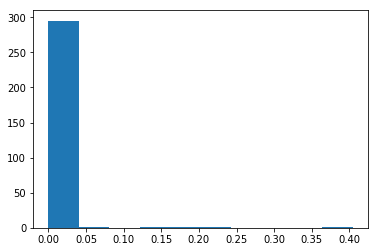

In [8]:
import matplotlib.pyplot as plt
%matplotlib inline
indices = hist_and_support(pca.weights, num_weights)

In [9]:
indices

array([ 94, 207, 289, 268, 283, 244,  66, 111])

DOING COMBO [-1e-05, 6.000000000000002e-06]
DOING COMBO [-8.000000000000001e-06, 1.6940658945086007e-21]
DOING COMBO [-1e-05, -1e-05]
DOING COMBO [-6e-06, -6e-06]
DOING COMBO [-1e-05, 8.000000000000003e-06]
DOING COMBO [-6e-06, -4e-06]
DOING COMBO [-8.000000000000001e-06, 2.000000000000001e-06]
DOING COMBO [-1e-05, -8.000000000000001e-06]
DOING COMBO [-1e-05, 1e-05]
DOING COMBO [-6e-06, -1.9999999999999995e-06]
DOING COMBO [-1e-05, -6e-06]
DOING COMBO [-8.000000000000001e-06, 4.000000000000001e-06]
DOING COMBO [-8.000000000000001e-06, -1e-05]
DOING COMBO [-1e-05, -4e-06]
DOING COMBO [-6e-06, 1.6940658945086007e-21]
DOING COMBO [-8.000000000000001e-06, 6.000000000000002e-06]
DOING COMBO [-8.000000000000001e-06, -8.000000000000001e-06]
DOING COMBO [-1e-05, -1.9999999999999995e-06]
DOING COMBO [-6e-06, 2.000000000000001e-06]
DOING COMBO [-8.000000000000001e-06, -6e-06]
DOING COMBO [-1e-05, 1.6940658945086007e-21]
DOING COMBO [-8.000000000000001e-06, 8.000000000000003e-06]
DOING COMBO [-6e

/home/anthony/.pyenv/versions/3.6.3/envs/personal/lib/python3.6/site-packages/numpy/core/numeric.py:501: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order)


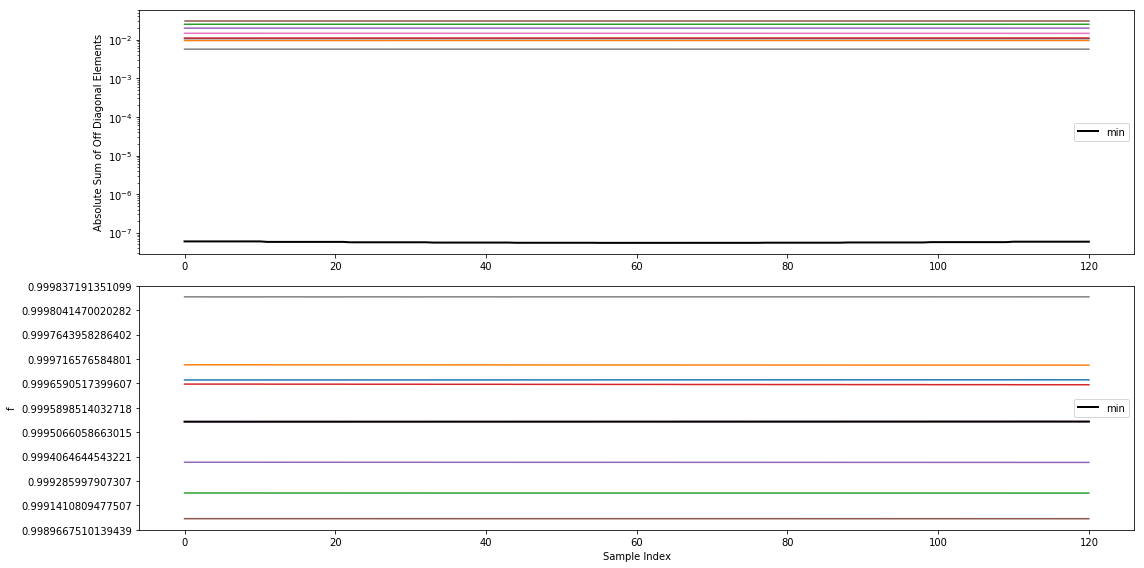

In [10]:

#pca1 = dill.load(open('../../../repos/randomized_controls/' + pcas[choice], 'rb'))
pca1 = dill.load(open(filename, 'rb'))
subweights = pca.weights[indices]
pca1.controlset = [pca1.controlset[i] for i in indices]
pca1.probs = list(np.array(subweights.T/sum(subweights)).T)
off_diagonals(pca1, scale)


SUPPORT:0.999985434878872
NUM CONTROLS: 8


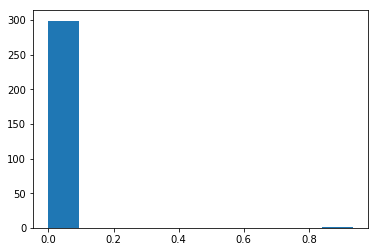

In [11]:
import matplotlib.pyplot as plt
num_weights0 = num_weights
%matplotlib inline
indices = hist_and_support(pca.weights_0, num_weights0)

SUPPORT:0.999985434878872
NUM CONTROLS: 8
DOING COMBO [-1e-05, 6.000000000000002e-06]
DOING COMBO [-1e-05, -1e-05]
DOING COMBO [-8.000000000000001e-06, 1.6940658945086007e-21]
DOING COMBO [-6e-06, -6e-06]
DOING COMBO [-1e-05, -8.000000000000001e-06]
DOING COMBO [-6e-06, -4e-06]
DOING COMBO [-8.000000000000001e-06, 2.000000000000001e-06]
DOING COMBO [-1e-05, 8.000000000000003e-06]
DOING COMBO [-6e-06, -1.9999999999999995e-06]
DOING COMBO [-1e-05, -6e-06]
DOING COMBO [-8.000000000000001e-06, 4.000000000000001e-06]
DOING COMBO [-1e-05, 1e-05]
DOING COMBO [-6e-06, 1.6940658945086007e-21]
DOING COMBO [-1e-05, -4e-06]
DOING COMBO [-8.000000000000001e-06, 6.000000000000002e-06]
DOING COMBO [-8.000000000000001e-06, 8.000000000000003e-06]
DOING COMBO [-1e-05, -1.9999999999999995e-06]
DOING COMBO [-8.000000000000001e-06, -1e-05]
DOING COMBO [-6e-06, 2.000000000000001e-06]
DOING COMBO [-8.000000000000001e-06, 1e-05]
DOING COMBO [-6e-06, 4.000000000000001e-06]
DOING COMBO [-6e-06, -1e-05]
DOING CO

/home/anthony/.pyenv/versions/3.6.3/envs/personal/lib/python3.6/site-packages/numpy/core/numeric.py:501: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order)


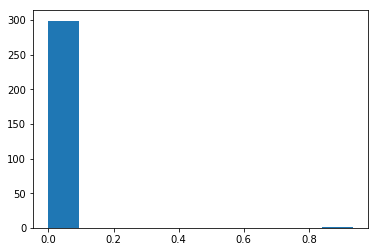

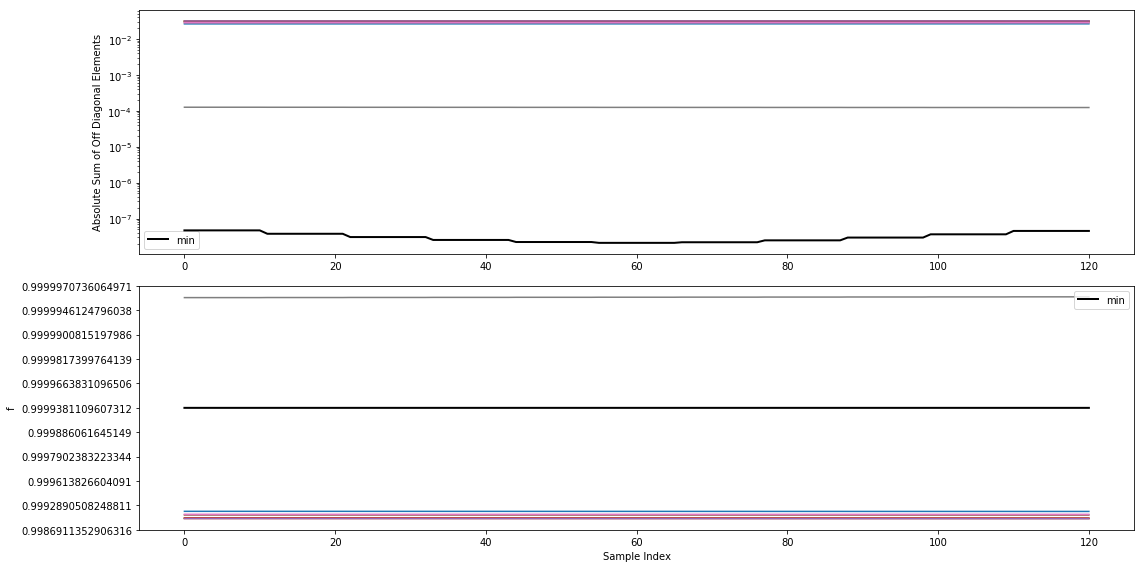

In [12]:
import matplotlib.pyplot as plt

#pca0 = dill.load(open('../../../repos/randomized_controls/' + pcas[choice], 'rb'))
pca0 = dill.load(open(filename, 'rb'))
indices = hist_and_support(pca.weights_0, num_weights0)
subweights = pca.weights_0[indices]
pca0.controlset = [pca0.controlset[i] for i in indices]
pca0.probs = list(np.array(subweights.T/sum(subweights)).T)
off_diagonals(pca0, scale)


In [13]:
# off_diagonals2(pca1, pca0, scale/2)

# 750

DOING COMBO [-8e-05, -8e-05]
DOING COMBO [-6.400000000000001e-05, 1.3552527156068805e-20]
DOING COMBO [-8e-05, 4.8000000000000015e-05]
DOING COMBO [-4.8e-05, -4.8e-05]
DOING COMBO [-8e-05, -6.400000000000001e-05]
DOING COMBO [-8e-05, 6.400000000000002e-05]
DOING COMBO [-6.400000000000001e-05, 1.600000000000001e-05]
DOING COMBO [-4.8e-05, -3.2e-05]
DOING COMBO [-8e-05, -4.8e-05]
DOING COMBO [-6.400000000000001e-05, 3.2000000000000005e-05]
DOING COMBO [-8e-05, 8e-05]
DOING COMBO [-8e-05, -3.2e-05]
DOING COMBO [-8e-05, -1.5999999999999996e-05]
DOING COMBO [-6.400000000000001e-05, 4.8000000000000015e-05]
DOING COMBO [-4.8e-05, -1.5999999999999996e-05]
DOING COMBO [-6.400000000000001e-05, -8e-05]
DOING COMBO [-8e-05, 1.3552527156068805e-20]
DOING COMBO [-6.400000000000001e-05, 6.400000000000002e-05]
DOING COMBO [-4.8e-05, 1.3552527156068805e-20]
DOING COMBO [-6.400000000000001e-05, -6.400000000000001e-05]
DOING COMBO [-8e-05, 1.600000000000001e-05]
DOING COMBO [-6.400000000000001e-05, -4.8e

DOING COMBO [-3.2e-05, 1.3552527156068805e-20]
DOING COMBO [1.3552527156068805e-20, -1.5999999999999996e-05]
DOING COMBO [-1.5999999999999996e-05, 3.2000000000000005e-05]
DOING COMBO [-1.5999999999999996e-05, -8e-05]
DOING COMBO [-3.2e-05, 1.600000000000001e-05]
DOING COMBO [-1.5999999999999996e-05, 4.8000000000000015e-05]
DOING COMBO [1.3552527156068805e-20, 1.3552527156068805e-20]
DOING COMBO [-1.5999999999999996e-05, -6.400000000000001e-05]
DOING COMBO [-1.5999999999999996e-05, 6.400000000000002e-05]
DOING COMBO [1.3552527156068805e-20, 6.400000000000002e-05]
DOING COMBO [-1.5999999999999996e-05, 8e-05]
DOING COMBO [1.3552527156068805e-20, 1.600000000000001e-05]
DOING COMBO [-1.5999999999999996e-05, -4.8e-05]
DOING COMBO [1.3552527156068805e-20, 8e-05]
DOING COMBO [1.3552527156068805e-20, 3.2000000000000005e-05]
DOING COMBO [1.3552527156068805e-20, -8e-05]
DOING COMBO [1.600000000000001e-05, -8e-05]
DOING COMBO [-1.5999999999999996e-05, -3.2e-05]
DOING COMBO [1.3552527156068805e-20,

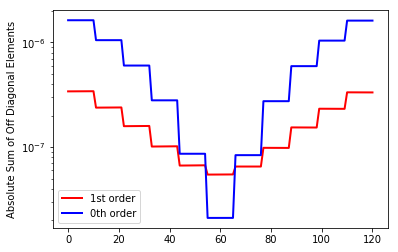

In [14]:
off_diagonals2(pca1, pca0, scale/8)